<div style="display: flex; justify-content: center;">
    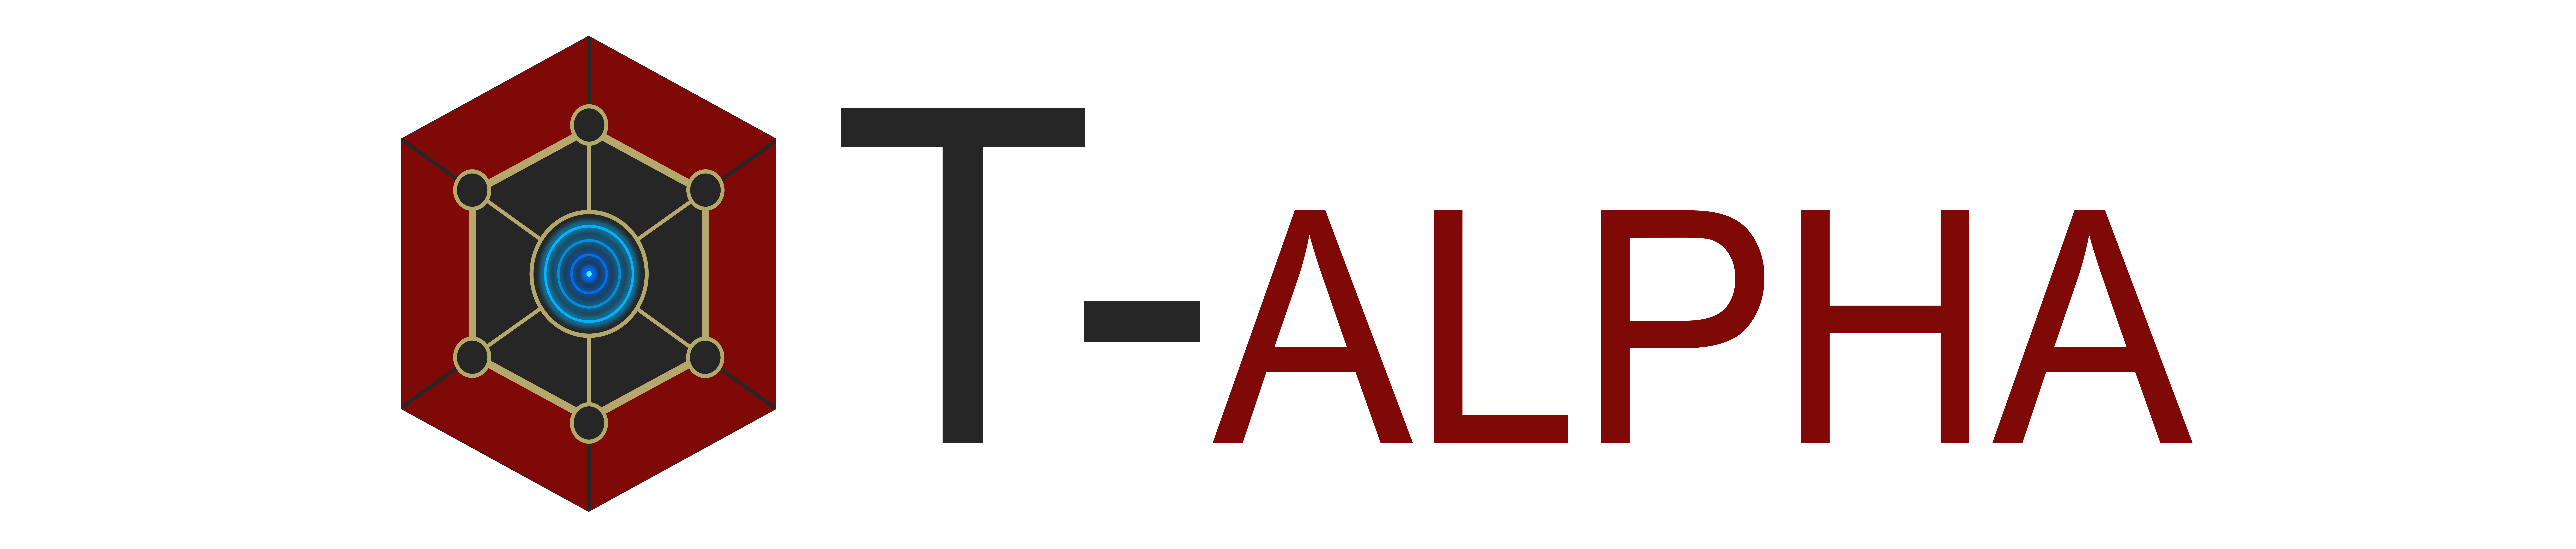
</div>

This Colab notebook provides a streamlined pipeline for predicting the binding affinity (p<i>K</i><sub>d</sub>) between a protein and a ligand using **T-ALPHA**. The pipeline supports multiple input modes and automatically handles essential preprocessing, feature extraction, and model inference.

For details about T-ALPHA, refer to the associated **[preprint on bioRxiv](https://www.biorxiv.org/content/10.1101/2024.12.19.629497v1)**. To access the source code, visit the **[GitHub repository](https://github.com/gregory-kyro/T-ALPHA)**.

---

### **How to Use This Notebook**
1. **Run the Setup**: Click the ▶ button to execute the first cluster of Setup cells (~7m 30s).
2. **Input Data**: Provide either:
   - Protein PDB file and ligand SDF file
   - Protein amino acid sequence and ligand SMILES string
   - Protein PDB ID and ligand SMILES string
3. **Run the Prediction**: Adjust parameters (e.g., visualization preferences) and execute the main cell for binding affinity prediction.

**Performance Tip**: For optimal performance, use an **A100 GPU** if available, by going to `Runtime` → `Change runtime type` and selecting `A100 GPU` under `Hardware accelerator`.

---

### **Time Estimates**
- **Installations**: ~3m 30s
- **File Retrieval**: ~4m
- **Structure Prediction with Chai-1 (for protein sequence or PDB ID inputs only)**: ~2m
- **Data Featurization**: ~10s
- **T-ALPHA Prediction**: < 1s

---

### **Example Inputs**
You can use the following example inputs to test the notebook, corresponding to the crystal structure of the C(30) carotenoid dehydrosqualene synthase from Staphylococcus aureus complexed with BPH-673:

- Protein PDB ID:
```python
'3acx'

- Protein sequence:
```python
'AAAAAAMTMMDMNFKYCHKIMKKHSKSFSYAFDLLPEDQRKAVWAIYAVCRKIDDSIDVYGDIQFLNQIKEDIQSIEKYPYEYHHFQSDRRIMMALQHVAQHKNIAFQSFYNLIDTVYKDQHFTMFETDAELFGYCYGVAGTVGEVLTPILSDHETHQTYDVARRLGESLQLINILRDVGEDFENERIYFSKQRLKQYEVDIAEVYQNGVNNHYIDLWEYYAAIAEKDFRDVMDQIKVFSIEAQPIIELAARIYIEILDEVRQANYTLHERVFVEKRKKAKLFHEINSKYHRI'

- Ligand SMILES string:
```python
'CC(C)NCCCOc1ccc(cc1CC=C)c2ccccc2'
```

### **Contact Information**
For questions or issues, please contact:
- Gregory Kyro: [gregory.kyro@yale.edu](mailto:gregory.kyro@yale.edu)

# Setup

## Ensure reproducibility

In [ ]:
# Ensure reproducibility in CUDA operations by setting the CuBLAS workspace configuration
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

## Install packages

In [ ]:
!pip install torchvision==0.18.1
import torchvision

import torch
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch_geometric

!apt-get update
!apt-get install -y python3-openbabel

!pip install biopython rdkit biopandas pykeops chai_lab pytorch_lightning py3Dmol

## Import packages

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Standard library imports
import os
import sys
import math
import logging
import shutil
import random
import time
import re
from pathlib import Path
from tempfile import NamedTemporaryFile

# General-purpose libraries
import numpy as np
import pandas as pd
import pickle
import requests

# PyTorch and related libraries
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data, Batch

# Bioinformatics libraries
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.PDB import MMCIFParser, PDBParser, PDBIO
from Bio.SeqUtils import seq1

# RDKit libraries
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Disable RDKit warnings

# Open Babel libraries
from openbabel import pybel, openbabel

# PyKeOps for clustering
from pykeops.torch import LazyTensor
from pykeops.torch.cluster import grid_cluster

# Biopandas for parsing PDB and Mol2 files
from biopandas.pdb import PandasPdb
from biopandas.mol2 import PandasMol2

# Visualization libraries
from IPython.display import display, HTML
import py3Dmol

# Project-specific libraries
from chai_lab.chai1 import run_inference

## Retrieve T-ALPHA software

In [ ]:
# Clone T-ALPHA repository
!git clone https://github.com/gregory-kyro/T-ALPHA.git

## Retrieve files

In [ ]:
# Retrieve T-ALPHA model parameters
!wget -O T-ALPHA_params.ckpt "https://zenodo.org/records/14514685/files/T-ALPHA_params.ckpt?download=1"

# Retrieve model parameters for pretrained SMILES transformer encoder for MLM
!wget -O SMILES_transformer_params.pt "https://zenodo.org/records/14516013/files/Transformer_Encoder_for_SMILES.pt?download=1"

# Retrieve pretraining data for SMILES transformer encoder for MLM
!wget -O SMILES_transformer_pretraining_data.csv "https://zenodo.org/records/14516013/files/Transformer_Encoder_for_SMILES_pretraining_data.csv?download=1"

In [ ]:
# Retrieve the ESM2 model and alphabet
esm_model, esm_alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t36_3B_UR50D")

## Pretrained SMILES transformer encoder

In [ ]:
# Define a class for the transformer dataset
class Transformer_Dataset(Dataset):
    """
    Dataset class for the Transformer model.

    Args:
        data_path (str): The path to the data file.
        block_size (int): The block size for padding the sequences.

    Attributes:
        smiles (pd.Series): The SMILES data from the dataset.
        smiles_regex (re.Pattern): The regular expression pattern for tokenizing SMILES strings.
        vocab (list): The vocabulary of special tokens and characters.
        stoi (dict): A mapping of characters to their corresponding indices in the vocabulary.
        itos (dict): A mapping of indices to their corresponding characters in the vocabulary.
        block_size (int): The block size for padding the sequences.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(idx): Returns the item at the given index.

    """

    # Define the class constructor
    def __init__(self, data_path=None, block_size=155):

        # Retrieve the SMILES strings from the data file
        data = pd.read_csv(data_path)
        self.smiles = data["SMILES"]

        # Tokenize the SMILES strings
        self.smiles_regex = re.compile(
            "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9]|<MASK>|<pad>|[CLS]|[EOS])"
        )
        special_tokens = {"<MASK>", "<pad>", "[CLS]", "[EOS]"}

        # Build the vocabulary
        characters = {
            ch
            for smile in self.smiles
            for ch in self.smiles_regex.findall(smile.strip())
        }
        self.vocab = sorted(list(special_tokens | characters))

        # Create mappings for the vocabulary
        self.stoi = {ch: i for i, ch in enumerate(self.vocab)}
        self.itos = {i: ch for i, ch in enumerate(self.vocab)}

        self.block_size = 2 + block_size

    # Method to return the length of the dataset
    def __len__(self):
        return len(self.smiles)

    # Method to return the item at the given index
    def __getitem__(self, idx):

        # Tokenize the SMILES string and pad it to the block size
        smiles = "[CLS]" + self.smiles[idx].strip() + "[EOS]"
        smiles_tokens = self.smiles_regex.findall(smiles)
        smiles += "<pad>" * (self.block_size - len(smiles_tokens))

        # Retrieve the token indices
        true_token_idx = [self.stoi[s] for s in self.smiles_regex.findall(smiles)]

        # Mask the tokens
        mask_idx = []
        for s in range(len(smiles_tokens)):
            if random.random() < 0.15:
                mask_idx.append(False)
                num = random.random()
                if num >= 0.2:
                    smiles_tokens[s] = "<MASK>"
                elif num >= 0.1:
                    smiles_tokens[s] = self.vocab[
                        int(random.random() * len(self.vocab))
                    ]
            else:
                mask_idx.append(True)

        # Identify the masked tokens
        mask_idx += [True] * (self.block_size - len(mask_idx))
        masked_smiles = "".join(smiles_tokens)

        # Pad to the block size
        masked_smiles += "<pad>" * (
            self.block_size - len(self.smiles_regex.findall(masked_smiles))
        )
        masked_token_idx = [
            self.stoi[s] for s in self.smiles_regex.findall(masked_smiles)
        ]

        return (
            torch.tensor(masked_token_idx, dtype=torch.long),
            torch.tensor(true_token_idx, dtype=torch.long),
            torch.tensor(mask_idx),
        )


# Define the transformer model
class Transformer_Model(nn.Module):
    """
    Transformer model for sequence generation.

    Args:
        vocab_size (int): Size of the vocabulary.
        embed_dim (int): Dimension of the token embeddings.
        block_size (int): Size of the input sequence.
        n_layers (int): Number of transformer blocks.
        extract_features (bool): Whether to extract features instead of generating output.

    Attributes:
        token_embed (nn.Embedding): Token embedding layer.
        position_embed (nn.Parameter): Positional embedding layer.
        dropout (nn.Dropout): Dropout layer.
        blocks (nn.ModuleList): List of transformer blocks.
        layer_norm (nn.LayerNorm): Layer normalization layer.
        output (nn.Linear): Output layer.
        extract_features (bool): Whether to extract features instead of generating output.

    Methods:
        forward(idx, admet_props=None, scaffold_idx=None, return_attention_weights=False):
            Forward pass of the model.

    """

    # Define the class constructor
    def __init__(
        self,
        vocab_size=None,
        embed_dim=768,
        block_size=155,
        n_layers=10,
        extract_features=False,
    ):

        super().__init__()

        self.extract_features = extract_features

        # Define token and position embeddings
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.position_embed = nn.Parameter(torch.zeros(1, block_size, embed_dim))

        self.dropout = nn.Dropout(0.1)
        self.blocks = nn.ModuleList(
            [
                Transformer_Block(embed_dim=embed_dim)
                for _ in range(n_layers)
            ]
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.output = nn.Linear(embed_dim, vocab_size, bias=True)

    # Method to perform the forward pass
    def forward(
        self, idx, return_attention_weights=False
    ):

        # Get batch and time dimensions
        B, T = idx.size()

        # Define token and position embeddings
        token_embeddings = self.token_embed(idx)
        position_embeddings = self.position_embed[:, :T, :]

        # Add token, position, and type embeddings
        x = self.dropout(token_embeddings + position_embeddings)

        # Perform the forward pass through the transformer blocks
        attention_weights_list = []
        for block in self.blocks:

            if return_attention_weights:
                x, attention_weights = block(x, return_attention_weights=True)
                attention_weights_list.append(attention_weights)

            else:
                x = block(x)

        # Apply layer normalization
        x = self.layer_norm(x)

        if self.extract_features:
            cls_embedding = x[:, 0, :]
            return cls_embedding.detach()

        # Generate the output logits
        logits = self.output(x)

        if return_attention_weights:
            return logits, attention_weights_list

        else:
            return logits


# Define the transformer block
class Transformer_Block(nn.Module):
    """
    Transformer Block class.

    Args:
        embed_dim (int): The dimensionality of the input embeddings. Default is 256.

    Attributes:
        layer_norm1 (nn.LayerNorm): Layer normalization module.
        layer_norm2 (nn.LayerNorm): Layer normalization module.
        attention (Self_Attention): Self-attention module.
        mlp (nn.Sequential): Multi-layer perceptron module.

    Methods:
        forward(x, return_attention_weights=False): Performs forward pass of the transformer block.

    """

    # Define the class constructor
    def __init__(self, embed_dim=768):
        super().__init__()

        # Define layer normalization modules
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        # Define self-attention module
        self.attention = Self_Attention(embed_dim=embed_dim)

        # Define multi-layer perceptron module
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(0.1),
        )

    # Method to perform the forward pass
    def forward(self, x, return_attention_weights=False):

        if return_attention_weights:
            y, attention_weights = self.attention(
                self.layer_norm1(x), return_attention_weights=True
            )
            x = x + y
            x = x + self.mlp(self.layer_norm2(x))
            return x, attention_weights

        else:
            y = self.attention(self.layer_norm1(x))
            x = x + y
            x = x + self.mlp(self.layer_norm2(x))
            return x


# Define the self-attention module
class Self_Attention(nn.Module):
    """
    Self-Attention module that performs attention mechanism on the input sequence.

    Args:
        embed_dim (int): The dimensionality of the input embeddings.
        n_heads (int): The number of attention heads.

    Attributes:
        query (nn.Linear): Linear layer for computing the query.
        key (nn.Linear): Linear layer for computing the key.
        value (nn.Linear): Linear layer for computing the value.
        dropout (nn.Dropout): Dropout layer for regularization.
        projection (nn.Linear): Linear layer for projecting the output.
        n_heads (int): The number of attention heads.

    Methods:
        forward(x, return_attention_weights=False): Performs forward pass of the self-attention module.

    """

    # Define the class constructor
    def __init__(self, embed_dim=768, n_heads=12):
        super().__init__()

        # Define linear layers for query, key, and value vectors
        self.query = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value = nn.Linear(embed_dim, embed_dim, bias=False)

        self.dropout = nn.Dropout(0.1)
        self.projection = nn.Linear(embed_dim, embed_dim)

        self.n_heads = n_heads

    # Method to perform the forward pass
    def forward(self, x, return_attention_weights=False):
        # Get batch, time, and channel dimensions
        B, T, C = x.size()

        # Compute query, key, and value vectors
        q = self.query(x).view(B, T, self.n_heads, C // self.n_heads)
        k = self.key(x).view(B, T, self.n_heads, C // self.n_heads)
        v = self.value(x).view(B, T, self.n_heads, C // self.n_heads)
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        scale_factor = 1 / math.sqrt(C // self.n_heads)
        attn_bias = torch.zeros(T, T, dtype=q.dtype, device=q.device)

        # Compute the attention weights
        attn_weight = torch.matmul(q, k.transpose(-2, -1)) * scale_factor
        attn_weight += attn_bias
        attn_weight = torch.softmax(attn_weight, dim=-1)
        attn_weight = self.dropout(attn_weight)

        # Multiply the attention weights by the value vectors
        y = torch.matmul(attn_weight, v)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Map the output to the embedding dimension
        y = self.projection(y)

        y = self.dropout(y)

        if return_attention_weights:
            return y, attn_weight

        else:
            return y


# Define a class for the transformer feature extractor
class Transformer_Feature_Extractor(torch.nn.Module):
    """
    A class representing a Transformer feature extractor.

    Args:
        model_parameters (str): The path to the model parameters file.
        training_data (str): The path to the training data.
        device (str, optional): The device to use for computation. Must be either 'cpu' or 'gpu'. Defaults to 'gpu' if available.

    Attributes:
        device (torch.device): The device used for computation.
        dataset (Transformer_Dataset): The dataset used for training.
        model (Transformer_Model): The Transformer model used for feature extraction.

    Methods:
        extract_features: Extracts features from input smiles.

    """

    # Define the class constructor
    def __init__(self, model_parameters=None,
                training_data=None,
                device="gpu"):
        super().__init__()
        assert device in ["cpu", "gpu"], "Device must be either 'cpu' or 'gpu'."
        self.device = torch.device(
            "cuda:0" if (device == "gpu" and torch.cuda.is_available()) else "cpu"
        )

        # Load the dataset and model
        self.dataset = Transformer_Dataset(
            data_path=training_data
        )
        self.model = Transformer_Model(
            vocab_size=len(self.dataset.vocab),
            block_size=self.dataset.block_size,
            extract_features=True,
        ).to(self.device)

        # Load the model parameters
        checkpoint = torch.load(model_parameters, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"], strict=True)

        self.model.eval()

    # Method to extract features from input smiles
    def extract_features(self, smiles):

        # Tokenize the SMILES string and pad it to the block size
        smiles = "[CLS]" + smiles.strip() + "[EOS]"
        smiles_tokens = self.dataset.smiles_regex.findall(smiles)
        smiles += "<pad>" * (self.dataset.block_size - len(smiles_tokens))
        token_idx = (
            torch.tensor(
                [
                    self.dataset.stoi[s]
                    for s in self.dataset.smiles_regex.findall(smiles)
                ],
                dtype=torch.long,
            )
            .unsqueeze(0)
            .to(self.device)
        )

        with torch.no_grad():
            # Extract the features
            features = self.model(token_idx).squeeze(0)

        return features

In [ ]:
# Define a feature extractor variable
transformer_feature_extractor = Transformer_Feature_Extractor(model_parameters='/content/SMILES_transformer_params.pt',
                                                              training_data='/content/SMILES_transformer_pretraining_data.csv')

## Protein sequence retrieval

In [ ]:
def get_protein_sequence(pdb_id):
    """
    Fetches the amino acid sequence of a protein given its PDB ID using the RCSB REST API.

    Parameters:
        pdb_id (str): The PDB ID of the protein.

    Returns:
        str: The amino acid sequence of the protein, or None if retrieval fails.

    Raises:
        ValueError: If the PDB ID is invalid or the API returns an error.
    """
    # Define the URL for the API call
    url = f'https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/1'

    # Send the request
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        try:
            data = response.json()
            sequence = data['entity_poly']['pdbx_seq_one_letter_code_can'].replace('\n', '')
            return sequence
        except (KeyError, ValueError) as e:
            raise ValueError(f"Failed to parse response for PDB ID {pdb_id}: {e}")
    else:
        raise ValueError(f"Failed to retrieve data for PDB ID {pdb_id}. Status Code: {response.status_code}")


## Chai-1 inference

In [ ]:
def predict_structure_with_chai1(protein_sequence: str, ligand_smiles: str, output_dir: str) -> str:
    """
    Given a protein sequence and a ligand SMILES string, this function:
      - Creates a FASTA file with two entries (protein and ligand).
      - Runs Chai1 inference to predict the best protein-ligand complex structure.
      - Returns the path to the best predicted structure (CIF file).

    Args:
        protein_sequence (str): The amino acid sequence of the protein.
        ligand_smiles (str): The SMILES string representing the ligand.
        output_dir (str): Directory to store the inference results.

    Returns:
        str: Path to the best predicted structure (CIF file).
    """
    # Ensure output directory exists
    output_path = Path(output_dir)
    if output_path.exists():
        shutil.rmtree(output_path)
    output_path.mkdir(parents=True, exist_ok=True)

    # Create a temporary FASTA file
    with NamedTemporaryFile(suffix=".fasta", delete=False) as tmp_fasta:
        fasta_path = tmp_fasta.name

    # Create SeqRecords for protein and ligand
    protein_record = SeqRecord(
        Seq(protein_sequence),
        id="protein|name=protein",
        description=""
    )

    ligand_record = SeqRecord(
        Seq(ligand_smiles),
        id="ligand|name=ligand",
        description=""
    )

    # Write to FASTA
    SeqIO.write([protein_record, ligand_record], fasta_path, "fasta")

    # Run Chai1 inference
    candidates = run_inference(
        fasta_file=Path(fasta_path),
        output_dir=output_path,
        num_trunk_recycles=3,
        num_diffn_timesteps=200,
        seed=42,
        device=torch.device("cuda:0"),
        use_esm_embeddings=True,
    )

    # Identify best structure
    cif_paths = candidates.cif_paths
    scores = [rd.aggregate_score for rd in candidates.ranking_data]
    best_cif = cif_paths[np.argmax(scores)]

    # Copy the best structure to a clear final filename
    best_structure_path = output_path / "best_structure.cif"
    shutil.copy(best_cif, best_structure_path)

    # Cleanup temporary FASTA
    os.remove(fasta_path)

    return str(best_structure_path)


In [ ]:
def add_hydrogens_and_save(molecule, output_file, output_format):
    """Add hydrogens to the given molecule and save it in the specified format, overwriting if needed."""
    molecule.OBMol.AddHydrogens()
    output_file_obj = pybel.Outputfile(output_format, output_file, overwrite=True)  # Overwrite existing files
    output_file_obj.write(molecule)
    output_file_obj.close()

def extract_protein_and_ligand_from_cif(
    cif_file: str,
    output_dir: str = '/content/chai1_results/',
    pdbid: str = "structure",
    ligand_resname: str = "LIG"
) -> (str, str):
    """
    Given a Chai1-generated CIF file, this function:
      1. Parses the CIF to obtain a structure.
      2. Saves the combined structure as a PDB.
      3. Splits the PDB into protein and ligand parts based on the ligand_resname.
      4. Saves the protein part as a PDB file.
      5. Converts the ligand part to an SDF file using RDKit.
      6. Adds hydrogens to both protein and ligand and overwrites the files.

    Args:
        cif_file (str): Path to the Chai1-generated CIF file.
        output_dir (str): Directory where output PDB and SDF files will be stored.
        pdbid (str): An identifier to use in the output filenames. Defaults to "structure".
        ligand_resname (str): Residue name used to identify the ligand in the PDB. Defaults to "LIG".

    Returns:
        (str, str): A tuple containing the paths to the hydrogen-added protein PDB and ligand SDF files.
    """

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Parse CIF and save combined PDB
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure(pdbid, cif_file)
    pdbio = PDBIO()
    pdbio.set_structure(structure)
    combined_pdb_file = output_dir / f"{pdbid}_combined_chai1.pdb"
    pdbio.save(str(combined_pdb_file))

    # Split into protein and ligand PDB files
    protein_lines = []
    ligand_lines = []

    with open(combined_pdb_file, 'r') as file:
        lines = file.readlines()

    # Identify ligand lines by residue name
    for line in lines:
        if f" {ligand_resname} " in line:
            ligand_lines.append(line)
        else:
            protein_lines.append(line)

    protein_file_name = output_dir / f"{pdbid}_protein_chai1.pdb"
    ligand_file_name_pdb = output_dir / f"{pdbid}_ligand_chai1.pdb"

    with open(protein_file_name, 'w') as protein_file:
        protein_file.writelines(protein_lines)

    with open(ligand_file_name_pdb, 'w') as ligand_file:
        ligand_file.writelines(ligand_lines)

    # Convert ligand PDB to SDF using RDKit
    ligand_sdf_file = output_dir / f"{pdbid}_ligand_chai1.sdf"
    ligand_mol = Chem.MolFromPDBFile(str(ligand_file_name_pdb), removeHs=False)
    if ligand_mol is None:
        raise ValueError("Could not parse ligand from PDB. Check ligand_resname or file integrity.")

    Chem.MolToMolFile(ligand_mol, str(ligand_sdf_file))

    # Add hydrogens to the protein PDB using Pybel
    # Protein is PDB format
    prot = next(pybel.readfile("pdb", str(protein_file_name)))
    add_hydrogens_and_save(prot, str(protein_file_name), "pdb")

    # Add hydrogens to the ligand SDF using Pybel
    lig = next(pybel.readfile("sdf", str(ligand_sdf_file)))
    add_hydrogens_and_save(lig, str(ligand_sdf_file), "sdf")


    return str(protein_file_name), str(ligand_sdf_file)


## ESM2 inference

In [ ]:
def get_esm2_embedding(pdb_file: str, esm_model, esm_alphabet) -> np.ndarray:
    """
    Given a protein PDB file, extract its amino acid sequence across all protein chains
    and produce the ESM2 embedding for that combined sequence.

    This function:
      - Parses the input PDB file to obtain the combined protein sequence from all chains.
      - Loads the ESM2 model and alphabet as done in the CSV-based code.
      - Converts the sequence into tokens with the model's batch_converter.
      - Runs the ESM2 model to obtain the per-residue representations.
      - Computes the average over residues to obtain a single embedding vector.

    Returns:
      np.ndarray: A 1D NumPy array containing the ESM2 embedding vector.

    Requirements:
      - torch
      - biopython
      - numpy
      - The ESM2 model weights will be automatically downloaded by torch.hub if not cached.
    """

    # Parse the PDB structure and gather all standard amino acid residues from all chains
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)

    # Collect all residues that are standard amino acids from all chains
    # We assume the CSV data was a single continuous sequence, so we replicate that here.
    # Sort chains by chain ID to ensure consistent ordering if needed.
    chains = sorted(structure.get_chains(), key=lambda c: c.id)
    residues = []
    for chain in chains:
        for res in chain.get_residues():
            if res.get_id()[0] == ' ':  # standard residue
                residues.append(res)

    # Convert residues to a single-letter amino acid sequence
    seq = "".join(seq1(res.get_resname()) for res in residues)
    if not seq:
        raise ValueError("No valid amino acid residues found in the provided PDB file.")

    # PDB ID placeholder for batch_converter
    pdb_id = "PDB_SEQ"

    # Convert the single protein sequence into tokens
    esm_batch_converter = esm_alphabet.get_batch_converter()
    batch_labels, batch_strs, batch_tokens = esm_batch_converter([(pdb_id, seq)])
    batch_lens = (batch_tokens != esm_alphabet.padding_idx).sum(1)

    # Run the model to get embeddings from layer 33 as done previously
    esm_model.eval()
    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    token_representations = results["representations"][33]

    # Compute the average embedding over all residues
    # Exclude the <cls> and <eos> tokens
    residue_reps = token_representations[0, 1:batch_lens[0]-1]
    sequence_representation = residue_reps.mean(0)

    # Return as a NumPy array
    return sequence_representation.cpu().numpy()


## RDKit 2D descriptor calculation

In [ ]:
def get_rdkit_vector(sdf_file: str) -> np.ndarray:
    """
    Given a ligand SDF file, compute a 209-dimensional RDKit descriptor vector,
    excluding the descriptor named 'SPS'.

    Steps:
      - Load the ligand from the given SDF file.
      - Exclude the 'SPS' descriptor from RDKit's default descriptor list.
      - Compute the remaining descriptors using RDKit's MoleculeDescriptorCalculator.
      - Return the resulting vector as a NumPy array.

    Args:
        sdf_file (str): Path to the ligand SDF file.

    Returns:
        np.ndarray: A 1D float32 NumPy array of length 209 containing the computed descriptors.
    """

    # Load the molecule from SDF
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mols = [m for m in suppl if m is not None]
    if len(mols) == 0:
        raise ValueError(f"No valid molecules found in {sdf_file}.")
    mol = mols[0]

    # Get all descriptor names, excluding 'SPS'
    all_descriptor_names = [d[0] for d in Descriptors.descList if d[0] != "SPS"]

    # Create a descriptor calculator for the selected descriptors
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(all_descriptor_names)

    # Compute the descriptors
    descriptors = calculator.CalcDescriptors(mol)

    # Convert to NumPy array
    rdkit_vector = np.array(descriptors, dtype=np.float32)

    if len(rdkit_vector) != 209:
        raise ValueError(f"Expected a vector of length 209, got {len(rdkit_vector)}.")

    return rdkit_vector


## Pretrained SMILES transformer encoder inference

In [ ]:
def get_transformer_vector(sdf_file: str, transformer_feature_extractor) -> np.ndarray:
    """
    Given a ligand SDF file, extract a transformer-based feature vector using a pretrained
    transformer feature extractor.

    Steps:
      - Load the ligand molecule from the SDF file.
      - Convert the molecule to a canonical SMILES representation.
      - Pass the canonical SMILES string to the transformer_feature_extractor to obtain the feature vector.
      - Return the feature vector as a NumPy array.

    Args:
        sdf_file (str): Path to the ligand SDF file.
        transformer_feature_extractor: An initialized transformer feature extractor object
                                       with a method `extract_features(smiles: str) -> np.ndarray`.

    Returns:
        np.ndarray: A 1D NumPy array containing the extracted feature vector.
    """

    # Load the ligand molecule from the SDF file
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mols = [m for m in suppl if m is not None]
    if len(mols) == 0:
        raise ValueError(f"No valid molecules found in {sdf_file}.")
    mol = mols[0]

    # Convert to canonical SMILES
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)

    # Extract features using the transformer model
    features = transformer_feature_extractor.extract_features(canonical_smiles)

    # Ensure the result is a NumPy array
    if not isinstance(features, np.ndarray):
        features = np.array(features.cpu(), dtype=np.float32)

    return features

## Protein pocket extraction

In [ ]:
def convert_ligand_to_mol2(ligand_file, output_mol2_file):
    """Convert ligand file (SDF or PDB) to MOL2 using Open Babel."""
    if ligand_file.endswith(".sdf"):
        lig_format = "sdf"
    elif ligand_file.endswith(".pdb"):
        lig_format = "pdb"
    else:
        raise ValueError("Unsupported ligand format. Only SDF and PDB are supported.")

    # Use Open Babel to convert the ligand to MOL2 format
    mol = next(pybel.readfile(lig_format, ligand_file))
    mol.write("mol2", output_mol2_file, overwrite=True)


""" define function to extract pocket from protein pdb """
def extract_pocket(protein_pdb, ligand_file, output_pocket_pdb):


  # Convert ligand file to MOL2 format if it's not already MOL2
  if not ligand_file.endswith(".mol2"):
    ligand_mol2 = '/content/ligand.mol2'
    convert_ligand_to_mol2(ligand_file, ligand_mol2)
  else:
    ligand_mol2 = ligand_file

  # read in protein pdb file
  protein = PandasPdb().read_pdb(protein_pdb)

  # define protein atoms dataframe
  protein_atom = protein.df['ATOM'].reset_index(drop=True)

  # create protein atom dictionary
  protein_atom_dict = protein_atom.to_dict('index')

  # define protein heteroatoms dataframe
  protein_hetatm =  protein.df['HETATM'].reset_index(drop=True)

  # create protein heteroatom dictionary
  protein_hetatm_dict = protein_hetatm.to_dict('index')

  # read in ligand mol2 file
  ligand = PandasMol2().read_mol2(ligand_mol2).df

  # define ligand non-H atoms dataframe
  ligand_nonh = ligand[ligand['atom_type'] != 'H'].reset_index(drop=True)

  # create ligand non-H atom dictionary
  ligand_nonh_dict = ligand_nonh.to_dict('index')

  # initialize lists to save IDs for residues and heteroatoms to keep in pocket file
  pocket_residues = []
  pocket_heteroatoms = []

  # for each protein atom:
  for j in range(len(protein_atom_dict)):

    # if residue number is not already saved in list
    if protein_atom_dict[j]['residue_number'] not in pocket_residues:

      # for each ligand non-H atom:
      for i in range(len(ligand_nonh_dict)):

        # if Euclidean distance is within 8 Angstroms:
        if np.sqrt((ligand_nonh_dict[i]['x'] - protein_atom_dict[j]['x_coord'])**2 + (ligand_nonh_dict[i]['y'] - protein_atom_dict[j]['y_coord'])**2 + (ligand_nonh_dict[i]['z'] - protein_atom_dict[j]['z_coord'])**2) <= 8:

          # save chain ID, residue number and insertion to list
          pocket_residues.append(str(protein_atom_dict[j]['chain_id'])+'_'+str(protein_atom_dict[j]['residue_number'])+'_'+str(protein_atom_dict[j]['insertion']))

          break

  # for each protein heteroatom:
  for k in range(len(protein_hetatm_dict)):

    # if residue number is not already saved in list
    if protein_hetatm_dict[k]['residue_number'] not in pocket_heteroatoms:

      # for each ligand non-H atom:
      for i in range(len(ligand_nonh_dict)):

        # if Euclidean distance is within 8 Angstroms:
        if np.sqrt((ligand_nonh_dict[i]['x'] - protein_hetatm_dict[k]['x_coord'])**2 + (ligand_nonh_dict[i]['y'] - protein_hetatm_dict[k]['y_coord'])**2 + (ligand_nonh_dict[i]['z'] - protein_hetatm_dict[k]['z_coord'])**2) <= 8:

          # save heteroatom ID to list
          pocket_heteroatoms.append(protein_hetatm_dict[k]['residue_number'])

          break

  # initialize list to store atoms that are included in saved residues
  atoms_to_keep = []

  # loop through atom dictionary
  for k,v in protein_atom_dict.items():

    # if atom is in saved list
    if str(v['chain_id'])+'_'+str(v['residue_number'])+'_'+str(v['insertion']) in pocket_residues:

      # append the atom number to new list
      atoms_to_keep.append(v['atom_number'])

  # define the atoms to include in pocket
  residues = protein_atom[(protein_atom['atom_number'].isin(atoms_to_keep))]

  # reset atom number ordering
  residues = residues.reset_index(drop=1)

  # initialize list to store heteroatoms that are included in saved heteroatom IDs
  hetatms_to_keep = []

  # loop through heteroatom dictionary
  for k,v in protein_hetatm_dict.items():

    # if heteroatom is in saved list
    if v['residue_number'] in pocket_heteroatoms and v['residue_name']=='HOH':

      # append the heteroatom number to new list
      hetatms_to_keep.append(v['atom_number'])

  # define the heteroatoms to include in pocket file
  heteroatoms = protein_hetatm[(protein_hetatm['atom_number'].isin(hetatms_to_keep))]

  # reset heteroatom number ordering
  heteroatoms = heteroatoms.reset_index(drop=1)

  # initialize biopandas object to write out pocket pdb file
  pred_pocket = PandasPdb()

  # define the atoms and heteroatoms of the object
  pred_pocket.df['ATOM'], pred_pocket.df['HETATM'] = residues, heteroatoms

  # save the created object to a pdb file
  return pred_pocket.to_pdb(output_pocket_pdb)

## Graph featurization

In [ ]:
# Define graph featurizer class
class Graph_Featurizer(object):

    """
    A class for generating graph-based features for molecular structures,
    including nodes and edges for protein-ligand complexes. The class supports
    various atomic and molecular properties such as van der Waals radii,
    electronegativity, polarizability, and more.

    Attributes:
        surface_features_bool (bool): Indicates whether surface features, including hydrogens, should be computed.
        atom_classes (list): List of atomic numbers for specific elements (e.g., C, O, N, etc.).
        ATOM_CODES (dict): Mapping of atomic numbers to one-hot encoding indices.
        VDW_RADII (dict): Van der Waals radii for atoms (in pm).
        ELECTRONEGATIVITY (dict): Pauling electronegativity values for atoms.
        POLARIZABILITY (dict): Dipole polarizability values for atoms.
        AMINO_ACID_TYPES (dict): Classification of amino acids by type (e.g., hydrophobic, polar, etc.).
        AMINO_ACID_TYPE_CODES (dict): One-hot encoding for amino acid types.
    """

    # Define the class constructor
    def __init__(self, surface_features_bool=False):

        self.surface_features_bool = surface_features_bool

        # Define the atom classes for C, O, N, S, F, P, Cl, Br, B, I, and other
        self.atom_classes = [(6), (8), (7), (16), (9), (15), (17), (35), (5), (53), (-1)]

        # add hydrogen if computing surface features
        if surface_features_bool:
            self.atom_classes.insert(0, (1))

        self.ATOM_CODES = {atomic_num: idx for idx, atomic_num in enumerate(self.atom_classes)}

        # Define the atomic Van der Waals radii (pm) <https://periodic.lanl.gov/89.shtml>
        self.VDW_RADII = {
            5: 192,  # Boron
            6: 170,  # Carbon
            7: 155,  # Nitrogen
            8: 152,  # Oxygen
            9: 135,  # Fluorine
            15: 180, # Phosphorus
            16: 180, # Sulfur
            17: 175, # Chlorine
            35: 183, # Bromine
            53: 198, # Iodine

            26: 194,  # Fe (Iron)
            44: 207,  # Ru (Ruthenium)
            34: 190,  # Se (Selenium)
            14: 210,  # Si (Silicon)
            77: 202,  # Ir (Iridium)
            33: 185,  # As (Arsenic)
            27: 192,  # Co (Cobalt)
            23: 179,  # V (Vanadium)
            78: 209,  # Pt (Platinum)
            45: 195,  # Rh (Rhodium)
            4: 153,   # Be (Beryllium)
            76: 216,  # Os (Osmium)
            75: 217,  # Re (Rhenium)
            29: 140,  # Cu (Copper)
            51: 206,  # Sb (Antimony)
            12: 173,  # Mg (Magnesium)
            30: 139,  # Zn (Zinc)
            52: 206,  # Te (Tellurium)
            }


        # Define the electronegativity values as per the Pauling scale
        self.ELECTRONEGATIVITY = {
            5: 2.04,   # Boron
            6: 2.55,   # Carbon
            7: 3.04,   # Nitrogen
            8: 3.44,   # Oxygen
            9: 3.98,   # Fluorine
            15: 2.19,  # Phosphorus
            16: 2.58,  # Sulfur
            17: 3.16,  # Chlorine
            35: 2.96,  # Bromine
            53: 2.66,  # Iodine

            26: 1.83,  # Fe (Iron)
            44: 2.20,  # Ru (Ruthenium)
            34: 2.55,  # Se (Selenium)
            14: 1.90,  # Si (Silicon)
            77: 2.20,  # Ir (Iridium)
            33: 2.18,  # As (Arsenic)
            27: 1.88,  # Co (Cobalt)
            23: 1.63,  # V (Vanadium)
            78: 2.28,  # Pt (Platinum)
            45: 2.28,  # Rh (Rhodium)
            4: 1.57,  # Be (Beryllium)
            76: 2.20,  # Os (Osmium)
            75: 1.90,  # Re (Rhenium)
            29: 1.90,  # Cu (Copper)
            51: 2.05,  # Sb (Antimony)
            12: 1.31,  # Mg (Magnesium)
            30: 1.65,  # Zn (Zinc)
            52: 2.10,  # Te (Tellurium)
            }


        # Define the static dipole polarizability values of neutral elements as defined <https://www.tandfonline.com/doi/full/10.1080/00268976.2018.1535143#d1e161>
        self.POLARIZABILITY = {
            5: 20.50,   # Boron
            6: 11.30,   # Carbon
            7: 7.40,   # Nitrogen
            8: 5.30,   # Oxygen
            9: 3.74,   # Fluorine
            15: 25.10,  # Phosphorus
            16: 19.40,  # Sulfur
            17: 14.60,  # Chlorine
            35: 21.00,  # Bromine
            53: 32.90,  # Iodine

            26: 62.00,  # Fe (Iron)
            44: 72.00,  # Ru (Ruthenium)
            34: 28.90,  # Se (Selenium)
            14: 37.30,  # Si (Silicon)
            77: 54.00,  # Ir (Iridium)
            33: 30.00,  # As (Arsenic)
            27: 55.00,  # Co (Cobalt)
            23: 87.00,  # V (Vanadium)
            78: 48.00,  # Pt (Platinum)
            45: 66.00,  # Rh (Rhodium)
            4: 37.74,  # Be (Beryllium)
            76: 57.00,  # Os (Osmium)
            75: 62.00,  # Re (Rhenium)
            29: 46.50,  # Cu (Copper)
            51: 43.00,  # Sb (Antimony)
            12: 71.20, # Mg (Magnesium)
            30: 38.67,  # Zn (Zinc)
            52: 38.00,  # Te (Tellurium)
                }

        # Classify each amino acid type as hydrophobic, polar, basic, or acidic
        self.AMINO_ACID_TYPES = {
            "ALA": "hydrophobic",
            "VAL": "hydrophobic",
            "LEU": "hydrophobic",
            "ILE": "hydrophobic",
            "MET": "hydrophobic",
            "PHE": "hydrophobic",
            "TYR": "hydrophobic",
            "TRP": "hydrophobic",
            "SER": "polar",
            "THR": "polar",
            "ASN": "polar",
            "GLN": "polar",
            "LYS": "basic",
            "ARG": "basic",
            "HIS": "basic",
            "ASP": "acidic",
            "GLU": "acidic",
            "CYS": "polar", # special case
            "GLY": "hydrophobic", # special case
            "PRO": "hydrophobic", # special case
            "LIG": "ligand", # case for ligand atoms
        }

        if surface_features_bool:
            self.VDW_RADII.update({1: 120}) # Hydrogen
            self.ELECTRONEGATIVITY.update({1: 2.20}) # Hydrogen
            self.POLARIZABILITY.update({1: 4.51}) # Hydrogen



        # Define the amino acid type one-hot encodings
        self.AMINO_ACID_TYPE_CODES = {
            "hydrophobic": 0,
            "polar": 1,
            "basic": 2,
            "acidic": 3,
            "ligand": 4,
        }


    # Method to encode the atomic number into a one-hot vector
    def encode_atomic_number(self, atomic_num):
        encoding = np.zeros(len(self.atom_classes))
        if atomic_num in self.ATOM_CODES:
            encoding[self.ATOM_CODES[atomic_num]] = 1.0
        else:
            encoding[self.ATOM_CODES[-1]] = 1.0 # Other class
        return encoding


    # Method to encode amino acid type into a one-hot vector
    def encode_amino_acid_type(self, residue_name, graph_type='protein'):
        if graph_type == 'protein':
            type_str = self.AMINO_ACID_TYPES.get(residue_name, "unknown")
            encoding = np.zeros(len(self.AMINO_ACID_TYPE_CODES) - 1)
            if type_str in self.AMINO_ACID_TYPE_CODES:
                encoding[self.AMINO_ACID_TYPE_CODES[type_str]] = 1.0
            return encoding

        elif graph_type == 'complex':
            if residue_name == "LIG":
                type_str = "ligand"
            else:
                type_str = self.AMINO_ACID_TYPES.get(residue_name, "unknown") # Default to unknown if not found
            encoding = np.zeros(len(self.AMINO_ACID_TYPE_CODES))
            if type_str in self.AMINO_ACID_TYPE_CODES:
                encoding[self.AMINO_ACID_TYPE_CODES[type_str]] = 1.0
            return encoding


    # Method to determine if an atom is hydrophobic
    def is_hydrophobic(self, atom):
        atomic_num = atom.GetAtomicNum()
        formal_charge = atom.GetFormalCharge()

        # Check if the atom is neutral
        if formal_charge != 0:
            return False

        # Neutral carbon atoms not bonded to N, O, or F
        if atomic_num == 6:  # Carbon
            bonded_elements = {neighbor.GetAtomicNum() for neighbor in openbabel.OBAtomAtomIter(atom)}
            if not (7 in bonded_elements or 8 in bonded_elements or 9 in bonded_elements):
                return True

        # Neutral sulfur in specific oxidation states (simplified check)
        elif atomic_num == 16:  # Sulfur
            hybridization = atom.GetHyb()
            if hybridization in [2, 3]:  # Simplified logic for SH or sulfur with sp2/sp3 hybridization
                return True

        # Neutral halogens (Cl, Br, I)
        elif atomic_num in [17, 35, 53]:  # Chlorine, Bromine, Iodine
            return True

        return False


    # Method to calculate the features for a molecule
    def get_node_features(self, molecule, source='ligand', complex_bool=False):
        # print('We are in the get_node_features method')
        node_features = []
        coordinates = []

        for i, atom in enumerate(molecule):
            # print('We are processing atom number', i)
            if atom.atomicnum > 1 or self.surface_features_bool: # Skip hydrogen atoms unless computing surface features

                atomic_number_encoding = self.encode_atomic_number(atom.atomicnum)
                vdw_radius = self.VDW_RADII.get(atom.atomicnum, 183.32) # default to mean value
                formal_charge = atom.OBAtom.GetFormalCharge()
                partial_charge = atom.OBAtom.GetPartialCharge()
                electronegativity = self.ELECTRONEGATIVITY.get(atom.atomicnum, 2.29) # default to mean value
                polarizability = self.POLARIZABILITY.get(atom.atomicnum, 39.12) # default to mean value
                hydrophobic = 1.0 if self.is_hydrophobic(atom.OBAtom) else 0.0
                aromatic = 1.0 if atom.OBAtom.IsAromatic() else 0.0
                acceptor = 1.0 if atom.OBAtom.IsHbondAcceptor() else 0.0
                donor = 1.0 if atom.OBAtom.IsHbondDonor() else 0.0
                ring = 1.0 if atom.OBAtom.IsInRing() else 0.0
                hybridization = atom.OBAtom.GetHyb()
                chirality = 1.0 if atom.OBAtom.IsChiral() else 0.0
                total_degree = len([neighbor for neighbor in openbabel.OBAtomAtomIter(atom.OBAtom)])
                heavy_degree = sum(1 for neighbor in openbabel.OBAtomAtomIter(atom.OBAtom) if neighbor.GetAtomicNum() > 1)
                hetero_degree = sum(1 for neighbor in openbabel.OBAtomAtomIter(atom.OBAtom) if neighbor.GetAtomicNum() not in [1, 6])
                hydrogen_degree = sum(1 for neighbor in openbabel.OBAtomAtomIter(atom.OBAtom) if neighbor.GetAtomicNum() == 1)

                atom_coords = np.array([atom.OBAtom.GetX(), atom.OBAtom.GetY(), atom.OBAtom.GetZ()])
                coordinates.append(atom_coords)

                if complex_bool == True:
                    source_id = -1 if source == "protein" else 1
                    amino_acid_type_encoding = self.encode_amino_acid_type(atom.residue.name, 'complex') if source == "protein" else self.encode_amino_acid_type("LIG", 'complex')
                    node_features.append(
                        np.concatenate(
                        (
                            atomic_number_encoding, # C, O, N, S, F, P, Cl, Br, B, I, other
                            amino_acid_type_encoding, # hydropobic, polar, basic, acidic, ligand

                            [formal_charge],
                            [hydrophobic],
                            [aromatic],
                            [acceptor],
                            [donor],
                            [ring],
                            [hybridization],
                            [chirality],
                            [total_degree],
                            [heavy_degree],
                            [hetero_degree],
                            [hydrogen_degree],
                            [source_id],

                            [vdw_radius],
                            [partial_charge],
                            [electronegativity],
                            [polarizability],

                    )
                    )
                    )

                elif complex_bool == False:
                    if source == "protein":
                        amino_acid_type_encoding = self.encode_amino_acid_type(atom.residue.name, 'protein')
                        node_features.append(
                            np.concatenate(
                            (
                                atomic_number_encoding, # C, O, N, S, F, P, Cl, Br, B, I, other
                                amino_acid_type_encoding, # hydropobic, polar, basic, acidic

                                [formal_charge],
                                [hydrophobic],
                                [aromatic],
                                [acceptor],
                                [donor],
                                [ring],
                                [hybridization],
                                [chirality],
                                [total_degree],
                                [heavy_degree],
                                [hetero_degree],
                                [hydrogen_degree],

                                [vdw_radius],
                                [partial_charge],
                                [electronegativity],
                                [polarizability],
                        )
                        )
                        )

                    elif source == "ligand":
                        node_features.append(
                            np.concatenate(
                            (
                                atomic_number_encoding, # C, O, N, S, F, P, Cl, Br, B, I, other

                                [formal_charge],
                                [hydrophobic],
                                [aromatic],
                                [acceptor],
                                [donor],
                                [ring],
                                [hybridization],
                                [chirality],
                                [total_degree],
                                [heavy_degree],
                                [hetero_degree],
                                [hydrogen_degree],

                                [vdw_radius],
                                [partial_charge],
                                [electronegativity],
                                [polarizability],
                        )
                        )
                        )

        # Format and return the features
        node_features = np.array(node_features, dtype=np.float32)
        # print('We converted the node features to a numpy array')
        coordinates = np.array(coordinates, dtype=np.float32)
        # print('We converted the coordinates to a numpy array')
        return node_features, coordinates


    def get_bond_based_edges(self, molecule):

        # Remove hydrogens from the molecule
        molecule.OBMol.DeleteHydrogens()

        edge_idx, edge_attr = [], []
        for bond in openbabel.OBMolBondIter(molecule.OBMol):

            atom1 = bond.GetBeginAtomIdx() - 1  # OpenBabel indices start at 1, so subtract 1 for 0-indexing
            atom2 = bond.GetEndAtomIdx() - 1

            if bond.GetBeginAtom().GetAtomicNum() == 1 or bond.GetEndAtom().GetAtomicNum() == 1:
                continue  # Skip hydrogen bonds

            bond_order = bond.GetBondOrder()

            atom1_coords = np.array([bond.GetBeginAtom().GetX(), bond.GetBeginAtom().GetY(), bond.GetBeginAtom().GetZ()])
            atom2_coords = np.array([bond.GetEndAtom().GetX(), bond.GetEndAtom().GetY(), bond.GetEndAtom().GetZ()])

            distance = np.linalg.norm(atom1_coords - atom2_coords)

            aromatic = 1.0 if bond.IsAromatic() else 0.0
            ring = 1.0 if bond.IsInRing() else 0.0

            atom1_electronegativity = self.ELECTRONEGATIVITY.get(bond.GetBeginAtom().GetAtomicNum(), 0)
            atom2_electronegativity = self.ELECTRONEGATIVITY.get(bond.GetEndAtom().GetAtomicNum(), 0)
            electronegativity_difference = np.abs(atom1_electronegativity - atom2_electronegativity)

            atom1_charge = bond.GetBeginAtom().GetPartialCharge()
            atom2_charge = bond.GetEndAtom().GetPartialCharge()

            electrostatic_energy = (atom1_charge * atom2_charge) / distance**2 # TODO: Add this as a feature

            edge_idx.append((atom1, atom2))
            edge_idx.append((atom2, atom1))
            edge_attr.append([bond_order, distance, aromatic, ring, electronegativity_difference, electrostatic_energy])
            edge_attr.append([bond_order, distance, aromatic, ring, electronegativity_difference, electrostatic_energy])

        return edge_idx, edge_attr


    def get_distance_based_edges(self, protein, ligand, distance_threshold=4.5): # 4.5 A corresponds to hydrophobic threshold deined by ProLIF

        # remove hydrogens from the protein and ligand
        protein.OBMol.DeleteHydrogens()
        ligand.OBMol.DeleteHydrogens()

        # Get the coordinates and electronegativity of the protein atoms
        protein_coords, protein_electronegativities, protein_charges = [], [], []
        for atom in openbabel.OBMolAtomIter(protein.OBMol):
            if atom.GetAtomicNum() == 1:
                continue  # Skip hydrogen atoms

            protein_coords.append(np.array([atom.GetX(), atom.GetY(), atom.GetZ()]))
            protein_electronegativities.append(self.ELECTRONEGATIVITY.get(atom.GetAtomicNum(), 0))
            protein_charges.append(atom.GetPartialCharge())

        # Get the coordinates and electronegativity of the ligand atoms
        ligand_coords, ligand_electronegativities, ligand_charges = [], [], []
        for atom in openbabel.OBMolAtomIter(ligand.OBMol):
            if atom.GetAtomicNum() == 1:
                continue # Skip hydrogen atoms

            ligand_coords.append(np.array([atom.GetX(), atom.GetY(), atom.GetZ()]))
            ligand_electronegativities.append(self.ELECTRONEGATIVITY.get(atom.GetAtomicNum(), 0))
            ligand_charges.append(atom.GetPartialCharge())

        protein_coords = np.array(protein_coords)
        ligand_coords = np.array(ligand_coords)

        # Calculate the pairwise distances between protein and ligand atoms
        distances = np.linalg.norm(protein_coords[:, np.newaxis, :] - ligand_coords[np.newaxis, :, :], axis=2)
        protein_indices, ligand_indices = np.where(distances <= distance_threshold)

        # Offset ligand atom indices by the number of protein atoms
        edge_idx, edge_attr = [], []

        for i, j in zip(protein_indices, ligand_indices):
            ligand_index = j + len(protein_coords)

            distance = distances[i, j]
            electronegativity_difference = np.abs(protein_electronegativities[i] - ligand_electronegativities[j])


            electrostatic_energy = (protein_charges[i] * ligand_charges[j]) / distance**2 # TODO: Add this as a feature

            edge_idx.append((i, ligand_index))
            edge_idx.append((ligand_index, i))

            edge_attr.append([0, distance, 0, 0, electronegativity_difference, electrostatic_energy])
            edge_attr.append([0, distance, 0, 0, electronegativity_difference, electrostatic_energy])

        return edge_idx, edge_attr

    def get_protein_ligand_complex_edges(self, protein, ligand):

        # Get bond-based edges for protein and ligand
        protein_edges, protein_edge_attrs = self.get_bond_based_edges(protein)
        ligand_edges, ligand_edge_attrs = self.get_bond_based_edges(ligand)

        # Offset ligand atom indices
        ligand_edges_offset = [(i + protein.OBMol.NumAtoms(), j + protein.OBMol.NumAtoms()) for i, j in ligand_edges]

        # Assign binary interaction labels
        protein_edge_attrs = [attr + [0] for attr in protein_edge_attrs]  # 0 for protein-protein
        ligand_edge_attrs = [attr + [0] for attr in ligand_edge_attrs]  # 0 for ligand-ligand

        all_edges = protein_edges + ligand_edges_offset
        all_edge_attrs = protein_edge_attrs + ligand_edge_attrs

        # Get distance-based edges between protein and ligand
        protein_ligand_edges, protein_ligand_attrs = self.get_distance_based_edges(protein, ligand)
        protein_ligand_attrs = [attr + [1] for attr in protein_ligand_attrs]  # 1 for protein-ligand


        # Combine all edges
        all_edges += protein_ligand_edges
        all_edge_attrs += protein_ligand_attrs

        return all_edges, all_edge_attrs

In [ ]:
def get_graphs(connected_featurizer=None, unconnected_featurizer=None, protein_pocket_path=None, ligand_mol2_path=None, protein_path=None):

    """
    Generates graph-based features and attributes for a protein pocket, ligand,
    protein-ligand complex, and unconnected protein.

    Args:
        connected_featurizer (Graph_Featurizer): An instance of the `Graph_Featurizer`
            class for generating connected graph features (e.g., bonds and interactions).
        unconnected_featurizer (Graph_Featurizer): An instance of the `Graph_Featurizer`
            class for generating unconnected features (e.g., atomic-level features only).
        protein_pocket_path (str): Path to the protein pocket structure file (PDB format).
        ligand_mol2_path (str): Path to the ligand structure file (MOL2 format).
        protein_path (str): Path to the full protein structure file (PDB format).

    Returns:
        - protein_coords (np.ndarray): Coordinates of protein pocket atoms.
        - protein_features (np.ndarray): Features of protein pocket atoms.
        - prot_edges (list of tuples): Bond-based edges for the protein pocket.
        - prot_attrs (list of lists): Attributes of bond-based edges for the protein pocket.
        - ligand_coords (np.ndarray): Coordinates of ligand atoms.
        - ligand_features (np.ndarray): Features of ligand atoms.
        - lig_edges (list of tuples): Bond-based edges for the ligand.
        - lig_attrs (list of lists): Attributes of bond-based edges for the ligand.
        - complex_coords (np.ndarray): Coordinates of protein-ligand complex atoms.
        - complex_features (np.ndarray): Features of protein-ligand complex atoms.
        - complex_edges (list of tuples): Edges (both bond-based and distance-based)
            for the protein-ligand complex.
        - complex_attrs (list of lists): Attributes of edges for the protein-ligand complex.
        - prot_withH_coords (np.ndarray): Coordinates of protein atoms (with hydrogens).
        - prot_withH_atom_types (np.ndarray): One-hot encoded atom types for the protein
            (with hydrogens).
        - prot_withH_features (np.ndarray): Features of protein atoms (excluding atom types)
            for the protein (with hydrogens).
        """

    # Process protein pocket
    prot = next(pybel.readfile("pdb",protein_pocket_path))
    protein_features, protein_coords = connected_featurizer.get_node_features(prot, source='protein', complex_bool=False)
    prot_edges, prot_attrs = connected_featurizer.get_bond_based_edges(prot)

    # Process ligand
    lig = next(pybel.readfile("mol2", ligand_mol2_path))
    ligand_features, ligand_coords = connected_featurizer.get_node_features(lig, source='ligand', complex_bool=False)
    lig_edges, lig_attrs = connected_featurizer.get_bond_based_edges(lig)

    # Process protein-ligand complex
    protein_features_complex, protein_coords_complex = connected_featurizer.get_node_features(prot, source='protein', complex_bool=True)
    ligand_features_complex, ligand_coords_complex = connected_featurizer.get_node_features(lig, source='ligand', complex_bool=True)
    complex_features = np.concatenate((protein_features_complex, ligand_features_complex), axis=0)
    complex_coords = np.concatenate((protein_coords_complex, ligand_coords_complex), axis=0)
    complex_edges, complex_attrs = connected_featurizer.get_protein_ligand_complex_edges(prot, lig)

    # Process unconnected protein
    prot_withH = next(pybel.readfile("pdb", protein_path))
    prot_withH_features, prot_withH_coords = unconnected_featurizer.get_node_features(prot_withH, source='protein', complex_bool=False)
    prot_withH_coords, prot_withH_atom_types, prot_withH_features = np.array(prot_withH_coords), np.array(prot_withH_features[:, :12]), np.array(prot_withH_features[:, 12:])

    return protein_coords, protein_features, prot_edges, prot_attrs, ligand_coords, ligand_features, lig_edges, lig_attrs, complex_coords, complex_features, complex_edges, complex_attrs, prot_withH_coords, prot_withH_atom_types, prot_withH_features

## Surface-oriented point cloud featurization

In [ ]:
def process(data, device):

    torch.manual_seed(42)

    P = {}
    L = {}

    # Atom information:
    P["atoms"] = data['atom_coords'].to(device)
    P["batch_atoms"] = data['atom_coords_batch'].to(device)
    # Chemical features: atom coordinates and types.
    P["atom_xyz"] = data['atom_coords'].to(device)
    P["atomtypes"] = data['atom_types'].to(device)
    P["atom_features"] = data['atom_features'].to(device)

    L["xyz"] = data['ligand_coords'].to(device)
    L["batch"] = data['ligand_coords_batch'].to(device)

    P["xyz"], P["normals"], P["batch"] = atoms_to_points_normals(
        atoms=P["atoms"].to(device),
        batch=P["batch_atoms"].to(device),
        atomtypes=P["atomtypes"].to(device))
    P["xyz"], P["normals"], P["batch"] = select_surface_pocket(P, L)
    return P["xyz"], P["normals"]


# need to add better comments here, todo
def atoms_to_points_normals(
    atoms,
    batch,
    num_atoms=12,
    distance=1.05,
    smoothness=0.5,
    resolution=1.0,
    nits=4,
    atomtypes=None,
    sup_sampling=20,
    variance=0.1
):
    """Turns a collection of atoms into an oriented point cloud.

    Sampling algorithm for protein surfaces, described in Fig. 3 of the paper.

    Args:
        atoms (Tensor): (N,3) coordinates of the atom centers `a_k`.
        batch (integer Tensor): (N,) batch vector, as in PyTorch_geometric.
        distance (float, optional): value of the level set to sample from
            the smooth distance function. Defaults to 1.05.
        smoothness (float, optional): radii of the atoms, if atom types are
            not provided. Defaults to 0.5.
        resolution (float, optional): side length of the cubic cells in
            the final sub-sampling pass. Defaults to 1.0.
        nits (int, optional): number of iterations . Defaults to 4.
        atomtypes (Tensor, optional): (N,6) one-hot encoding of the atom
            chemical types. Defaults to None.

    Returns:
        (Tensor): (M,3) coordinates for the surface points `x_i`.
        (Tensor): (M,3) unit normals `n_i`.
        (integer Tensor): (M,) batch vector, as in PyTorch_geometric.
    """
    # a) Parameters for the soft distance function and its level set:
    T = distance

    N, D = atoms.shape
    B = sup_sampling  # Sup-sampling ratio

    # Batch vectors:
    batch_atoms = batch
    batch_z = batch[:, None].repeat(1, B).view(N * B)

    # b) Draw N*B points at random in the neighborhood of our atoms
    z = atoms[:, None, :] + 10 * T * torch.randn(N, B, D).type_as(atoms)
    z = z.view(-1, D)  # (N*B, D)

    # We don't want to backprop through a full network here!
    atoms = atoms.detach().contiguous()
    z = z.detach().contiguous()

    # N.B.: Test mode disables the autograd engine: we must switch it on explicitely.
    with torch.enable_grad():
        if z.is_leaf:
            z.requires_grad = True

        # c) Iterative loop: gradient descent along the potential
        # ".5 * (dist - T)^2" with respect to the positions z of our samples
        for it in range(nits):

            dists = soft_distances(
                x=atoms,
                y=z,
                batch_x=batch_atoms,
                batch_y=batch_z,
                smoothness=smoothness,
                atomtypes=atomtypes
            )
            Loss = ((dists - T) ** 2).sum()
            g = torch.autograd.grad(Loss, z)[0]
            z.data -= 0.5 * g

        # d) Only keep the points which are reasonably close to the level set:
        dists = soft_distances(
            atoms, z, batch_atoms, batch_z, smoothness=smoothness, atomtypes=atomtypes
        )
        margin = (dists - T).abs()
        mask = margin < variance * T

        # d') And remove the points that are trapped *inside* the protein:
        zz = z.detach()
        zz.requires_grad = True
        for it in range(nits):
            dists = soft_distances(
                atoms,
                zz,
                batch_atoms,
                batch_z,
                smoothness=smoothness,
                atomtypes=atomtypes
            )
            Loss = (1.0 * dists).sum()
            g = torch.autograd.grad(Loss, zz)[0]
            normals = F.normalize(g, p=2, dim=-1)  # (N, 3)
            zz = zz + 1.0 * T * normals

        dists = soft_distances(
            atoms, zz, batch_atoms, batch_z, smoothness=smoothness, atomtypes=atomtypes,
        )
        mask = mask & (dists > 1.5 * T)

        z = z[mask].contiguous().detach()
        batch_z = batch_z[mask].contiguous().detach()

        # e) Subsample the point cloud:
        points, batch_points = subsample(z, batch_z, scale=resolution)

        # f) Compute the normals on this smaller point cloud:
        p = points.detach()
        p.requires_grad = True
        dists = soft_distances(
            atoms,
            p,
            batch_atoms,
            batch_points,
            smoothness=smoothness,
            atomtypes=atomtypes
        )
        Loss = (1.0 * dists).sum()
        g = torch.autograd.grad(Loss, p)[0]
        normals = F.normalize(g, p=2, dim=-1)  # (N, 3)
    points = points - 0.5 * normals
    return points.detach(), normals.detach(), batch_points.detach()


def soft_distances(x, y, batch_x, batch_y, smoothness=0.5, atomtypes=None):
    """Computes a soft distance function to the atom centers of a protein.

    Implements Eq. (1) of the paper in a fast and numerically stable way.

    Args:
        x (Tensor): (N,3) atom centers.
        y (Tensor): (M,3) sampling locations.
        batch_x (integer Tensor): (N,) batch vector for x, as in PyTorch_geometric.
        batch_y (integer Tensor): (M,) batch vector for y, as in PyTorch_geometric.
        smoothness (float, optional): atom radii if atom types are not provided. Defaults to .01.
        atomtypes (integer Tensor, optional): (N,6) one-hot encoding of the atom chemical types. Defaults to None.

    Returns:
        Tensor: (M,) values of the soft distance function on the points `y`.
    """
    # Build the (N, M, 1) symbolic matrix of squared distances:
    x_i = LazyTensor(x[:, None, :])  # (N, 1, 3) atoms
    y_j = LazyTensor(y[None, :, :])  # (1, M, 3) sampling points
    D_ij = ((x_i - y_j) ** 2).sum(-1)  # (N, M, 1) squared distances

    # Use a block-diagonal sparsity mask to support heterogeneous batch processing:
    D_ij.ranges = diagonal_ranges(batch_x, batch_y)

    if atomtypes is not None:

        atomic_radii = torch.cuda.FloatTensor(
            [120,  # Hydrogen
             170,  # Carbon
             152,  # Oxygen
             155,  # Nitrogen
             180, # Sulfur
             135,  # Fluorine
             180, # Phosphorus
             175, # Chlorine
             183, # Bromine
             192,  # Boron
             198, # Iodine
             190  # the average vdw radius of the atoms present in the dataset not included in this list
             ], device=x.device
        )

        # normalize radii to min
        atomic_radii = atomic_radii / atomic_radii.min()

        atomtype_radii = atomtypes * atomic_radii[None, :]  # n_atoms, n_atomtypes

        smoothness = torch.sum(
            smoothness * atomtype_radii, dim=1, keepdim=False
        )  # n_atoms, 1
        smoothness_i = LazyTensor(smoothness[:, None, None])

        mean_smoothness = (-D_ij.sqrt()).exp().sum(0)
        mean_smoothness_j = LazyTensor(mean_smoothness[None, :, :])
        mean_smoothness = (
            smoothness_i * (-D_ij.sqrt()).exp() / mean_smoothness_j
        )  # n_atoms, n_points, 1
        mean_smoothness = mean_smoothness.sum(0).view(-1)
        soft_dists = -mean_smoothness * (
            (-D_ij.sqrt() / smoothness_i).logsumexp(dim=0)
        ).view(-1)

    else:
        soft_dists = -smoothness * ((-D_ij.sqrt() / smoothness).logsumexp(dim=0)).view(
            -1
        )

    return soft_dists


def subsample(x, batch=None, scale=1.0):
    """Subsamples the point cloud using a grid (cubic) clustering scheme.

    The function returns one average sample per cell, as described in Fig. 3.e)
    of the paper.

    Args:
        x (Tensor): (N,3) point cloud.
        batch (integer Tensor, optional): (N,) batch vector, as in PyTorch_geometric.
            Defaults to None.
        scale (float, optional): side length of the cubic grid cells. Defaults to 1 (Angstrom).

    Returns:
        (M,3): sub-sampled point cloud, with M <= N.
    """

    if batch is None:  # Single protein case:
        labels = grid_cluster(x, scale).long()
        C = labels.max() + 1

        # We append a "1" to the input vectors, in order to
        # compute both the numerator and denominator of the "average"
        #  fraction in one pass through the data.
        x_1 = torch.cat((x, torch.ones_like(x[:, :1])), dim=1)
        D = x_1.shape[1]
        points = torch.zeros_like(x_1[:C])
        points.scatter_add_(0, labels[:, None].repeat(1, D), x_1)
        return (points[:, :-1] / points[:, -1:]).contiguous()


    else:
        # comment from dmasif people:

        # We process proteins using a for loop.
        # This is probably sub-optimal, but I don't really know
        # how to do more elegantly (this type of computation is
        # not super well supported by PyTorch).
        batch_size = torch.max(batch).item() + 1  # Typically, =32
        points, batches = [], []
        for b in range(batch_size):
            p = subsample(x[batch == b], scale=scale)
            points.append(p)
            batches.append(b * torch.ones_like(batch[: len(p)]))

    return torch.cat(points, dim=0), torch.cat(batches, dim=0)


def diagonal_ranges(batch_x=None, batch_y=None):
    """
    Encodes the block-diagonal structure associated with batch vectors. This function calculates indices for diagonal blocks (or ranges) and slices for batch vectors.

    Parameters:
        batch_x (torch.Tensor): A tensor representing a batch vector that indicates the batch membership of each item.
        batch_y (torch.Tensor): An optional second tensor representing another batch vector similar to batch_x. If not provided, it is assumed to be the same as batch_x (symmetric case).

    Returns:
        tuple: A tuple containing the diagonal block ranges and slices for both batch vectors, or None if no batches are provided.
    """

    def ranges_slices(batch):
        """
        Helper function to calculate the ranges and slices indices for a given batch vector.

        Parameters:
            batch (torch.Tensor): Batch tensor where each element indicates its batch membership.

        Returns:
            tuple: Tuple containing two elements:
                   - ranges: A tensor of size [num_batches, 2] where each row contains the start and end indices for each batch.
                   - slices: A tensor of indices for each batch, useful for slicing operations.
        """

        # Count the number of elements in each batch
        Ns = batch.bincount()

        # Compute cumulative sum to get the end index for each batch
        indices = Ns.cumsum(0)

        # Append zero at the beginning and combine with indices
        ranges = torch.cat((0 * indices[:1], indices))

        # Create a 2D tensor of [start_idx, end_idx] for each batch
        ranges = (torch.stack((ranges[:-1], ranges[1:])).t().int().contiguous().to(batch.device))

        # One-based indices for each batch
        slices = (1 + torch.arange(len(Ns))).int().to(batch.device)

        return ranges, slices

    if batch_x is None and batch_y is None:
        return None  # Exit if no batch data is provided
    elif batch_y is None:
        batch_y = batch_x  # Use batch_x for both if batch_y is not provided (symmetric case)

    ranges_x, slices_x = ranges_slices(batch_x)  # Calculate ranges and slices for batch_x
    ranges_y, slices_y = ranges_slices(batch_y)  # Calculate ranges and slices for batch_y

    return ranges_x, slices_x, ranges_y, ranges_y, slices_y, ranges_x


def select_surface_pocket(P_batch, L_batch):

    surface_list = []
    normal_list = []
    batch_list = []

    protein_batch_size = P_batch["batch_atoms"][-1].item() + 1

    for i in range(protein_batch_size):
        P, L = extract_single(P_batch, L_batch, i)
        # Calculate the distance from each protein point to each ligand point
        distances = torch.cdist(P["xyz"], L["xyz"], p=2)  # Calculate pairwise Euclidean (p=2) distances

        # Find the minimum distance to any ligand point for each protein point
        min_distances, _ = torch.min(distances, dim=1)

        # Create a mask for points within 8 angstroms
        _, indices = torch.sort(min_distances)
        mask = indices[:512]

        # Apply the mask to filter the protein points and their normals
        surface_list.append(P["xyz"][mask])
        normal_list.append(P["normals"][mask])
        batch_list.append(P["batch"][:mask.shape[0]])

    p_xyz = torch.cat(surface_list, dim=0)
    p_normals = torch.cat(normal_list, dim=0)
    p_batch = torch.cat(batch_list, dim=0)

    return p_xyz, p_normals, p_batch


def extract_single(P_batch, L_batch, number):
    P = {}
    suface_batch = P_batch["batch"] == number

    P["batch"] = P_batch["batch"][suface_batch]

    # Surface information:
    P["xyz"] = P_batch["xyz"][suface_batch]
    P["normals"] = P_batch["normals"][suface_batch]

    L = {}
    suface_batch = L_batch["batch"] == number

    L["batch"] = L_batch["batch"][suface_batch]

    # Ligand information:
    L["xyz"] = L_batch["xyz"][suface_batch]


    return P, L

## Feature scaling

### Connected graphs

In [ ]:
def scale_graph_features(
    ligand_node_features: np.ndarray,
    ligand_edge_attrs: np.ndarray,
    protein_node_features: np.ndarray,
    protein_edge_attrs: np.ndarray,
    complex_node_features: np.ndarray,
    complex_edge_attrs: np.ndarray,
    scaler_file: str
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Scale the continuous graph features for a single datapoint using pre-fitted scalers.

    Args:
        ligand_node_features (np.ndarray): Numpy array of ligand node features.
        ligand_edge_attrs (np.ndarray): Numpy array of ligand edge attributes.
        protein_node_features (np.ndarray): Numpy array of protein node features.
        protein_edge_attrs (np.ndarray): Numpy array of protein edge attributes.
        complex_node_features (np.ndarray): Numpy array of complex node features.
        complex_edge_attrs (np.ndarray): Numpy array of complex edge attributes.
        scaler_file (str): Path to the pickle file containing pre-fitted scalers
                           (a dict with 'node_scaler' and 'edge_scaler').

    Returns:
        tuple: Scaled versions of:
               (ligand_node_features_scaled,
                ligand_edge_attrs_scaled,
                protein_node_features_scaled,
                protein_edge_attrs_scaled,
                complex_node_features_scaled,
                complex_edge_attrs_scaled)

    """

    # Continuous feature indices for node and edge features
    node_continuous_indices = [-4, -3, -2, -1]  # Last 4 indices for node features
    edge_continuous_indices = [1, 4, 5]  # Indices 1, 4, and 5 for edge features

    # Load the pre-fitted scalers
    with open(scaler_file, 'rb') as f:
        scalers = pickle.load(f)
        node_scaler = scalers['node_scaler']
        edge_scaler = scalers['edge_scaler']

    def standardize_continuous_features(features, continuous_indices, scaler):

        # Ensure 'features' is a NumPy array
        features = np.asarray(features)


        # Split continuous and non-continuous features
        continuous_features = features[:, continuous_indices]
        non_continuous_features = np.delete(features, continuous_indices, axis=1)

        # Scale only the continuous features
        standardized_continuous_features = scaler.transform(continuous_features)

        # Concatenate back non-continuous and scaled continuous features
        return np.concatenate([non_continuous_features, standardized_continuous_features], axis=1)

    # Scale ligand node features
    ligand_node_features_scaled = standardize_continuous_features(ligand_node_features, node_continuous_indices, node_scaler)

    # Scale ligand edge attributes
    ligand_edge_attrs_scaled = standardize_continuous_features(ligand_edge_attrs, edge_continuous_indices, edge_scaler)

    # Scale protein node features
    protein_node_features_scaled = standardize_continuous_features(protein_node_features, node_continuous_indices, node_scaler)

    # Scale protein edge attributes
    protein_edge_attrs_scaled = standardize_continuous_features(protein_edge_attrs, edge_continuous_indices, edge_scaler)

    # Scale complex node features
    complex_node_features_scaled = standardize_continuous_features(complex_node_features, node_continuous_indices, node_scaler)

    # Scale complex edge attributes
    complex_edge_attrs_scaled = standardize_continuous_features(complex_edge_attrs, edge_continuous_indices, edge_scaler)

    return ligand_node_features_scaled,\
            ligand_edge_attrs_scaled,\
            protein_node_features_scaled,\
            protein_edge_attrs_scaled,\
            complex_node_features_scaled,\
            complex_edge_attrs_scaled

### Pretrained SMILES transformer encoder embedding

In [ ]:
def scale_transformer_embedding(transformer_embedding: np.ndarray, scaler_file: str) -> np.ndarray:
    """
    Given a transformer-based feature embedding and a pre-trained scaler file,
    this function returns the standardized (scaled) version of that embedding.

    Args:
        transformer_embedding (np.ndarray): The original transformer feature embedding to be scaled.
                                         Should be 1D or 2D. If 1D, it will be reshaped.
        scaler_file (str): Path to the pickle file containing the pre-trained scaler
                           dictionary with a key 'roberta_scaler'.

    Returns:
        np.ndarray: The scaled transformer feature embedding as a 1D NumPy array.
    """

    # Load the pre-trained scaler
    with open(scaler_file, 'rb') as f:
        roberta_scaler = pickle.load(f)['roberta_scaler']

    # Ensure the embedding is 2D for the scaler
    if transformer_embedding.ndim == 1:
        transformer_embedding = transformer_embedding.reshape(1, -1)

    # Scale the embedding
    standardized_embedding = roberta_scaler.transform(transformer_embedding)

    # Squeeze back to 1D array if applicable
    return standardized_embedding.squeeze()

### RDKit 2D descriptor vector

In [ ]:
def scale_rdkit_vector(rdkit_vector: np.ndarray, scaler_file: str) -> np.ndarray:
    """
    Given an RDKit descriptor vector and a pre-trained scaler file, this function
    returns the standardized (scaled) version of that vector.

    Args:
        rdkit_vector (np.ndarray): The RDKit descriptor vector to be scaled.
                                   Can be 1D or 2D. If 1D, it will be reshaped.
        scaler_file (str): Path to the pickle file containing the pre-trained scaler
                           dictionary with a key 'rdkit_scaler'.

    Returns:
        np.ndarray: The scaled RDKit descriptor vector as a 1D NumPy array.
    """

    # Load the pre-trained scaler
    with open(scaler_file, 'rb') as f:
        rdkit_scaler = pickle.load(f)['rdkit_scaler']

    # Ensure the vector is 2D for the scaler
    if rdkit_vector.ndim == 1:
        rdkit_vector = rdkit_vector.reshape(1, -1)

    # Scale the vector
    standardized_vector = rdkit_scaler.transform(rdkit_vector)

    # Handle NaN values by replacing them with the corresponding mean
    if np.isnan(standardized_vector).any():
        feature_means = rdkit_scaler.mean_  # Means of the features from the scaler
        standardized_vector = np.where(
            np.isnan(standardized_vector),
            feature_means,
            standardized_vector
        )

    # Return as a 1D array if it was originally 1D
    if standardized_vector.shape[0] == 1:
        return standardized_vector.squeeze()
    else:
        return standardized_vector

### ESM2 embedding

In [ ]:
def scale_esm2_embedding(esm2_embedding: np.ndarray, scaler_file: str) -> np.ndarray:
    """
    Given an ESM2 embedding vector and a pre-trained scaler file, this function
    returns the standardized (scaled) version of that embedding.

    Args:
        esm2_embedding (np.ndarray): The ESM2 embedding vector to be scaled.
                                     Can be 1D or 2D. If 1D, it will be reshaped.
        scaler_file (str): Path to the pickle file containing the pre-trained scaler
                           dictionary with a key 'esm2_scaler'.

    Returns:
        np.ndarray: The scaled ESM2 embedding as a 1D NumPy array.
    """

    # Load the pre-trained scaler
    with open(scaler_file, 'rb') as f:
        esm2_scaler = pickle.load(f)['esm2_scaler']

    # Ensure the embedding is 2D for the scaler
    if esm2_embedding.ndim == 1:
        esm2_embedding = esm2_embedding.reshape(1, -1)

    # Scale the embedding
    standardized_embedding = esm2_scaler.transform(esm2_embedding)

    # Return as a 1D array if it was originally 1D
    if standardized_embedding.shape[0] == 1:
        return standardized_embedding.squeeze()
    else:
        return standardized_embedding

### Unconnected graphs

In [ ]:
def scale_unconnected_graph_features(protein_node_features: np.ndarray, scaler_file: str) -> np.ndarray:
    """
    Given protein node features and a pre-trained scaler file, this function standardizes
    the continuous features and returns the standardized features.

    Args:
        protein_node_features (np.ndarray): The original protein node features array.
                                            Should be 2D (num_nodes x num_features).
        scaler_file (str): Path to the pickle file containing the pre-trained scaler
                           dictionary with a key 'protein_node_scaler'.

    Returns:
        np.ndarray: The standardized protein node features array.
    """

    # Continuous feature indices (last 4 indices are continuous)
    continuous_indices = [-4, -3, -2, -1]

    # Load the pre-trained scaler
    with open(scaler_file, 'rb') as f:
        protein_node_scaler = pickle.load(f)['protein_node_scaler']

    # Ensure the input features are a NumPy array
    protein_node_features = np.asarray(protein_node_features)

    # Split continuous and non-continuous features
    continuous_features = protein_node_features[:, continuous_indices]
    non_continuous_features = np.delete(protein_node_features, continuous_indices, axis=1)

    # Standardize the continuous features
    standardized_continuous_features = protein_node_scaler.transform(continuous_features)

    # Concatenate back non-continuous and standardized continuous features
    standardized_features = np.concatenate([non_continuous_features, standardized_continuous_features], axis=1)

    return standardized_features


## T-ALPHA inference

In [ ]:
# Load T-ALPHA modules for inference
os.chdir('/content/T-ALPHA')
from src.models.full_model import MetaModel
from src.training.lightning_module import MetaModelLightning

def run_single_inference(
    ckpt_path: str,
    scaled_esm2_embedding: np.ndarray,

    scaled_pocket_features: np.ndarray,
    pocket_coords: np.ndarray,
    pocket_edges: np.ndarray,
    scaled_pocket_edge_attrs: np.ndarray,

    protein_coords: np.ndarray,
    protein_atom_types: np.ndarray,
    scaled_protein_features: np.ndarray,
    protein_surface_coords: np.ndarray,
    protein_surface_norms: np.ndarray,

    scaled_rdkit_vector: np.ndarray,
    scaled_transformer_embedding: np.ndarray,

    scaled_ligand_features: np.ndarray,
    ligand_coords: np.ndarray,
    ligand_edges: np.ndarray,
    scaled_ligand_edge_attrs: np.ndarray,

    scaled_complex_features: np.ndarray,
    complex_coords: np.ndarray,
    complex_edges: np.ndarray,
    scaled_complex_edge_attrs: np.ndarray,

    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> float:
    """
    Given all the processed feature arrays for a single protein-ligand complex,
    this function:
    1. Loads the T-ALPHA model from a checkpoint.
    2. Constructs a data dictionary as done in the inference code.
    3. Performs a forward pass to predict binding affinity.
    4. Returns the predicted binding affinity (float).

    Args:
        ckpt_path (str): Path to the model checkpoint (.ckpt) file.
        ... (All the scaled and processed inputs as numpy arrays or torch tensors)
        device (str): The computation device ('cuda' or 'cpu').

    Returns:
        float: The predicted binding affinity.
    """

    # Ensure tensors are on the correct device
    def to_tensor(x, dtype=torch.float32):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=dtype)
        return x.to(device)

    # Convert all inputs to torch tensors on the correct device
    esm_vector = to_tensor(scaled_esm2_embedding)              # shape [1, D]
    rdkit_vector = to_tensor(scaled_rdkit_vector)              # shape [1, D]
    roberta_vector = to_tensor(scaled_transformer_embedding)   # shape [1, D]
    atom_coords = to_tensor(protein_coords)                    # shape [N_atoms, 3]
    atom_features = to_tensor(np.concatenate(
        [protein_atom_types, scaled_protein_features], axis=1))        # shape [N_atoms, D]
    surface_coords = to_tensor(protein_surface_coords)         # shape [N_surf, 3]
    surface_normals = to_tensor(protein_surface_norms)         # shape [N_surf, 3]

    # For a single sample, all batch indices are 0
    atom_coords_batch = torch.zeros(atom_coords.size(0), dtype=torch.long, device=device)
    surface_batch_idx = torch.zeros(surface_coords.size(0), dtype=torch.long, device=device)

    # Protein graph
    protein_graph_data = Data(
        node_feats=to_tensor(scaled_pocket_features),
        node_coords=to_tensor(pocket_coords),
        edge_index=to_tensor(pocket_edges, dtype=torch.long).t().contiguous(),
        edge_attr=to_tensor(scaled_pocket_edge_attrs),
    )
    protein_graph = Batch.from_data_list([protein_graph_data]).to(device)
    protein_graph_batch = torch.zeros(protein_graph_data.node_feats.size(0), dtype=torch.long, device=device)

    # Ligand graph
    ligand_graph_data = Data(
        node_feats=to_tensor(scaled_ligand_features),
        node_coords=to_tensor(ligand_coords),
        edge_index=to_tensor(ligand_edges, dtype=torch.long).t().contiguous(),
        edge_attr=to_tensor(scaled_ligand_edge_attrs),
    )
    ligand_graph = Batch.from_data_list([ligand_graph_data]).to(device)
    ligand_graph_batch = torch.zeros(ligand_graph_data.node_feats.size(0), dtype=torch.long, device=device)

    # Complex graph
    complex_graph_data = Data(
        node_feats=to_tensor(scaled_complex_features),
        node_coords=to_tensor(complex_coords),
        edge_index=to_tensor(complex_edges, dtype=torch.long).t().contiguous(),
        edge_attr=to_tensor(scaled_complex_edge_attrs),
    )
    complex_graph = Batch.from_data_list([complex_graph_data]).to(device)
    complex_graph_batch = torch.zeros(complex_graph_data.node_feats.size(0), dtype=torch.long, device=device)

    # Construct the data dictionary
    # Operator, label, pdbid are dummy since we only need a prediction
    data = {
        "esm_vector": esm_vector.unsqueeze(0),       # Ensure [1, D]
        "rdkit_vector": rdkit_vector.unsqueeze(0),
        "roberta_vector": roberta_vector.unsqueeze(0),
        "atom_coords_batch": atom_coords_batch,
        "atom_coords": atom_coords,
        "atom_features": atom_features,
        "surface_coords": surface_coords,
        "surface_normals": surface_normals,
        "surface_batch_idx": surface_batch_idx,
        "protein_graph": protein_graph,
        "protein_graph_batch": protein_graph_batch,
        "ligand_graph": ligand_graph,
        "ligand_graph_batch": ligand_graph_batch,
        "complex_graph": complex_graph,
        "complex_graph_batch": complex_graph_batch,
    }

    # Load the model
    model = MetaModel(device=device)
    lightning_model = MetaModelLightning.load_from_checkpoint(
        train_dataset=None,
        val_dataset=None,
        checkpoint_path=ckpt_path,
        model=model,
        batch_size=1,
        num_epochs=0,
        batch_norm=True
    ).to(device)
    lightning_model.eval()

    # Forward pass
    with torch.no_grad():
        output = lightning_model.model(data)  # output is a tensor of shape [1, 1]

    # output is the predicted binding affinity
    prediction = output.cpu().numpy().flatten()[0]
    return display_prediction(prediction)

In [ ]:
def update_parameter_keys(ckpt_path, output_path):
    """
    Update parameter keys in the checkpoint to handle all mismatched prefixes and names.

    Args:
        ckpt_path (str): Path to the original checkpoint file.
        output_path (str): Path to save the updated checkpoint file.

    Returns:
        None
    """
    # Load the checkpoint
    checkpoint = torch.load(ckpt_path, map_location="cpu")

    # Extract the state_dict
    state_dict = checkpoint['state_dict']

    # Create a new state_dict with renamed keys
    updated_state_dict = {}
    for key, value in state_dict.items():
        # Apply all replacements to handle mismatches
        new_key = key.replace("dmasif_model", "protein_surface_model")
        new_key = new_key.replace("esm_projector", "protein_sequence_projector")
        new_key = new_key.replace("esm_embedding_layer", "protein_sequence_embedding_layer")
        new_key = new_key.replace("rdkit_embedding_layer", "ligand_properties_embedding_layer")
        new_key = new_key.replace("roberta_projector", "ligand_sequence_projector")
        new_key = new_key.replace("roberta_embedding_layer", "ligand_sequence_embedding_layer")
        new_key = new_key.replace("protein_transformer_encoder_layer", "protein_surface_encoder_layer")
        new_key = new_key.replace("protein_transformer_encoder", "protein_surface_encoder")
        new_key = new_key.replace("esm_transformer_decoder_layer", "protein_sequence_decoder_layer")
        new_key = new_key.replace("esm_transformer_decoder", "protein_sequence_decoder")
        new_key = new_key.replace("protein_graph_transformer_decoder_layer", "protein_graph_decoder_layer")
        new_key = new_key.replace("protein_graph_transformer_decoder", "protein_graph_decoder")
        new_key = new_key.replace("ligand_transformer_encoder_layer", "ligand_properties_encoder_layer")
        new_key = new_key.replace("ligand_transformer_encoder", "ligand_properties_encoder")
        new_key = new_key.replace("roberta_transformer_decoder_layer", "ligand_sequence_decoder_layer")
        new_key = new_key.replace("roberta_transformer_decoder", "ligand_sequence_decoder")
        new_key = new_key.replace("ligand_graph_transformer_decoder_layer", "ligand_graph_decoder_layer")
        new_key = new_key.replace("ligand_graph_transformer_decoder", "ligand_graph_decoder")
        new_key = new_key.replace("complex_transformer_encoder_layer", "complex_encoder_layer")
        new_key = new_key.replace("complex_transformer_encoder", "complex_encoder")
        new_key = new_key.replace("protein_transformer_decoder_layer", "protein_decoder_layer")
        new_key = new_key.replace("protein_transformer_decoder", "protein_decoder")
        new_key = new_key.replace("ligand_transformer_decoder_layer", "ligand_decoder_layer")
        new_key = new_key.replace("ligand_transformer_decoder", "ligand_decoder")
        new_key = new_key.replace("complex_graph_transformer_output_embedding_layer", "complex_graph_embedding_layer")
        updated_state_dict[new_key] = value

    # Update the checkpoint with the new state_dict
    checkpoint['state_dict'] = updated_state_dict

    # Save the updated checkpoint
    torch.save(checkpoint, output_path)

In [ ]:
def display_prediction(prediction):
    """
    Displays the predicted binding affinity in a professional scientific format.

    Args:
        prediction (float): The predicted binding affinity.

    Returns:
        None
    """
    html_text = f"""
    <p style="font-size:16px;">
        <b>Predicted Binding Affinity (p<i>K</i><sub>d</sub>):</b> = {prediction:.3f}
    </p>
    """
    display(HTML(html_text))

## Protein-ligand complex visualization

In [ ]:
def visualize_protein_ligand(protein_file: str, ligand_file: str):
    """
    Visualizes a protein and a ligand in an optimized style for scientific papers.

    Args:
        protein_file (str): Path to the protein structure file (PDB format).
        ligand_file (str): Path to the ligand structure file (PDB or MOL/SDF format).

    Returns:
        py3Dmol.view: The py3Dmol view object for visualization.
    """
    # Initialize the viewer
    view = py3Dmol.view(width=800, height=600)

    # Load and add the protein file
    with open(protein_file, "r") as f:
        protein_data = f.read()
    view.addModel(protein_data, "pdb")
    view.setStyle({"model": 0}, {"cartoon": {"color": "#6379bf", "opacity": 0.90}})

    # Load and add the ligand file
    with open(ligand_file, "r") as f:
        ligand_data = f.read()
    ligand_format = "sdf" if ligand_file.endswith(".sdf") else "pdb"
    view.addModel(ligand_data, ligand_format)
    view.setStyle({"model": 1}, {"stick": {"color": "#7ec47e"}})  # Dim green for ligand

    # Enhance visual effects
    view.zoomTo()
    view.setBackgroundColor("black")  # White background for clarity

    return view

## Main execution

### Configure Logging

In [ ]:
class ElapsedFormatter(logging.Formatter):
    def __init__(self, fmt=None, start_time=None):
        super().__init__(fmt)
        self.start_time = start_time or time.time()

    def formatTime(self, record, datefmt=None):
        elapsed_seconds = record.created - self.start_time
        return f"{elapsed_seconds:.2f}s"

class CustomFilter(logging.Filter):
    def filter(self, record):
        # Customize filtering logic; allow only specific messages
        return "Inputs" in record.msg or "Retrieving" in record.msg or "Performing" in record.msg or "Featurizing" in record.msg or "Successfully" in record.msg or "Preparing" in record.msg

def reset_logging_start_time():
    global start_time
    start_time = time.time()
    for handler in logging.root.handlers:
        if isinstance(handler.formatter, ElapsedFormatter):
            handler.formatter.start_time = start_time

# Initialize custom formatter and filter
start_time = time.time()
formatter = ElapsedFormatter(fmt='%(asctime)s - %(message)s', start_time=start_time)
filter = CustomFilter()

# Clear existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Set up logging with the custom formatter and filter
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)
handler.addFilter(filter)
logging.root.addHandler(handler)
logging.root.setLevel(logging.INFO)

### T-ALPHA inference

In [ ]:
def main(protein_path=None, ligand_path=None, protein_sequence=None, pdb_id=None, ligand_smiles=None, visualization=True):

    """
    T-ALPHA: Protein-Ligand Binding Affinity Prediction Pipeline

    This function implements the T-ALPHA pipeline for predicting the binding affinity (pKd) of protein-ligand complexes.
    The pipeline supports multiple input modes:
    1. Provide protein and ligand files (PDB and SDF formats, respectively).
    2. Provide protein amino acid sequence and ligand SMILES string.
    3. Provide a PDB ID to fetch the protein sequence and ligand SMILES string.

    Features:
    - Predicts 3D structures from sequences using the CHAI1 module.
    - Extracts ESM2 embeddings, RDKit 2D descriptors, and SMILES transformer embeddings.
    - Constructs protein and ligand graphs with detailed atomic and bond features.
    - Generates a surface-oriented point cloud for the protein.
    - Scales and preprocesses all features to match the trained T-ALPHA model.
    - Runs inference using the trained T-ALPHA model to predict binding affinity.
    - Visualizes the protein-ligand complex with Py3Dmol.

    Output:
    - Predicted binding affinity (pKd) of the protein-ligand complex.
    - Optional 3D visualization of the protein-ligand complex.

    Parameters:
        protein_path (str): Path to the protein PDB file.
        ligand_path (str): Path to the ligand SDF file.
        protein_sequence (str): Protein sequence as a string.
        pdb_id (str): PDB ID to fetch the protein sequence.
        ligand_smiles (str): SMILES representation of the ligand.
        visualization (bool): Whether to visualize the protein-ligand complex.
    """
    # Reset the logging timer
    reset_logging_start_time()

    # Log all inputs
    inputs = {
        "protein_path": protein_path,
        "ligand_path": ligand_path,
        "protein_sequence": protein_sequence,
        "pdb_id": pdb_id,
        "ligand_smiles": ligand_smiles,
    }

    # Filter out None values
    non_none_inputs = {key: value for key, value in inputs.items() if value is not None}

    # Format the inputs for optimal presentation
    formatted_inputs = ", ".join(f"{key}: {value}" for key, value in non_none_inputs.items())

    # Log the formatted inputs
    logging.info(f"Inputs - {formatted_inputs}")

    # Ensure input validity
    if (protein_path and ligand_path) and (protein_sequence or pdb_id or ligand_smiles):
        raise ValueError("Provide either protein/ligand files or protein sequence/PDB ID with ligand SMILES.")
    if not ((protein_path and ligand_path) or (protein_sequence or pdb_id) and ligand_smiles):
        raise ValueError("You must provide either protein/ligand files or protein sequence/PDB ID with ligand SMILES.")

    # Add hydrogens to input files if provided
    if protein_path and ligand_path:
        logging.info("Preparing protein and ligand files...")

        # Add hydrogens to the protein
        protein_molecule = next(pybel.readfile("pdb", protein_path))
        add_hydrogens_and_save(protein_molecule, protein_path, "pdb")

        # Add hydrogens to the ligand
        ligand_molecule = next(pybel.readfile("sdf", ligand_path))
        add_hydrogens_and_save(ligand_molecule, ligand_path, "sdf")

    # Fetch sequence if PDB ID is provided
    if pdb_id:
        logging.info("Retrieving amino acid sequence...")
        protein_sequence = get_protein_sequence(pdb_id)
        if not protein_sequence:
            raise ValueError(f"Failed to retrieve protein sequence for PDB ID: {pdb_id}")

    # If sequences are provided, predict the structure and extract paths
    if protein_sequence and ligand_smiles:
        logging.info("Performing Chai-1 inference...")

        chai1_path = predict_structure_with_chai1(
            protein_sequence=protein_sequence,
            ligand_smiles=ligand_smiles,
            output_dir='/content/chai1_results'
        )

        protein_path, ligand_path = extract_protein_and_ligand_from_cif(chai1_path)

    logging.info("Featurizing data...")

    # Extract ESM2 embedding
    esm2_embedding = get_esm2_embedding(protein_path, esm_model, esm_alphabet)

    # Extract RDKit 2D descriptor vector
    rdkit_vector = get_rdkit_vector(ligand_path)

    # Extract SMILES transformer encoder embedding
    transformer_vector = get_transformer_vector(ligand_path, transformer_feature_extractor)

    # Extract protein pocket
    extract_pocket(protein_path, ligand_path, '/content/protein_pocket.pdb')

    # Define graph featurizer variables
    connected_featurizer =  Graph_Featurizer()
    unconnected_featurizer = Graph_Featurizer(surface_features_bool=True)

    # Obtain graphs
    pocket_coords, pocket_features, pocket_edges, pocket_edge_attrs, \
    ligand_coords, ligand_features, ligand_edges, ligand_edge_attrs, \
    complex_coords, complex_features, complex_edges, complex_edge_attrs, \
    protein_coords, protein_atom_types, protein_features = get_graphs(
        connected_featurizer=connected_featurizer,
        unconnected_featurizer=unconnected_featurizer,
        protein_pocket_path='/content/protein_pocket.pdb',
        ligand_mol2_path='/content/ligand.mol2',
        protein_path=protein_path)

    # Define data objects needed to obtain surface-oriented point cloud
    data = {
    'atom_coords': torch.tensor(protein_coords),
    'atom_coords_batch': torch.zeros(protein_coords.shape[0], dtype=torch.long),
    'atom_types': torch.tensor(protein_atom_types),
    'atom_features': torch.tensor(protein_features),
    'ligand_coords': torch.tensor(ligand_coords),
    'ligand_coords_batch': torch.zeros(ligand_coords.shape[0], dtype=torch.long)
}

    # Obtain surface coordinates and normals
    protein_surface_coords, protein_surface_norms = process(data, device=torch.device('cuda'))

    # Scale the featurized connected graphs
    scaled_ligand_features,   \
    scaled_ligand_edge_attrs, \
    scaled_pocket_features,   \
    scaled_pocket_edge_attrs, \
    scaled_complex_features,  \
    scaled_complex_edge_attrs = scale_graph_features(
                                            ligand_node_features=ligand_features,
                                            ligand_edge_attrs=ligand_edge_attrs,
                                            protein_node_features=pocket_features,
                                            protein_edge_attrs=pocket_edge_attrs,
                                            complex_node_features=complex_features,
                                            complex_edge_attrs=complex_edge_attrs,
                                            scaler_file='/content/T-ALPHA/data_scalers/connected_graph_scaler.pkl')

    # Scale the SMILES transformer encoder embedding
    scaled_transformer_embedding = scale_transformer_embedding(transformer_embedding=transformer_vector,
                                                          scaler_file='/content/T-ALPHA/data_scalers/ligand_sequence_scaler.pkl')

    # Scale the RDKit 2D descriptor vector
    scaled_rdkit_vector = scale_rdkit_vector(rdkit_vector=rdkit_vector,
                                         scaler_file='/content/T-ALPHA/data_scalers/ligand_properties_scaler.pkl')

    # Scale the ESM2 embedding
    scaled_esm2_embedding = scale_esm2_embedding(esm2_embedding=esm2_embedding,
                                            scaler_file='/content/T-ALPHA/data_scalers/protein_sequence_scaler.pkl')

    # Scale the featurized unconnected graphs
    scaled_protein_features = scale_unconnected_graph_features(protein_node_features=protein_features,
                                                               scaler_file='/content/T-ALPHA/data_scalers/unconnected_graph_scaler.pkl')

    # Update keys in parameter file
    update_parameter_keys('/content/T-ALPHA_params.ckpt', '/content/updated_T-ALPHA_params.ckpt')

    # Perform inference

    logging.info("Performing T-ALPHA inference...")

    prediction = run_single_inference(
        ckpt_path='/content/updated_T-ALPHA_params.ckpt',
        scaled_esm2_embedding=scaled_esm2_embedding,

        scaled_pocket_features=scaled_pocket_features,
        pocket_coords=pocket_coords,
        pocket_edges=pocket_edges,
        scaled_pocket_edge_attrs=scaled_pocket_edge_attrs,

        protein_coords=protein_coords,
        protein_atom_types=protein_atom_types,
        scaled_protein_features=scaled_protein_features,
        protein_surface_coords=protein_surface_coords,
        protein_surface_norms=protein_surface_norms,

        scaled_rdkit_vector=scaled_rdkit_vector,
        scaled_transformer_embedding=scaled_transformer_embedding,

        scaled_ligand_features=scaled_ligand_features,
        ligand_coords=ligand_coords,
        ligand_edges=ligand_edges,
        scaled_ligand_edge_attrs=scaled_ligand_edge_attrs,

        scaled_complex_features=scaled_complex_features,
        complex_coords=complex_coords,
        complex_edges=complex_edges,
        scaled_complex_edge_attrs=scaled_complex_edge_attrs)

    logging.info("Successfully completed T-ALPHA inference.")

    if visualization:
        logging.info("Preparing visualization of complex...")
        # show visual of protein-ligand complex
        view = visualize_protein_ligand(protein_path, ligand_path)
        view.show()

#  

In [ ]:
#@title Protein-Ligand Binding Affinity Prediction -- p<i>K<i><sub>d</sub>
#@markdown Provide the necessary inputs below and select options for the prediction.
#@markdown Choose your preferred input method and output format. Then click **Run** to predict.

# --- Input Type ---
input_type = "PDB ID and SMILES"  #@param ["File-based inputs", "Sequence and SMILES", "PDB ID and SMILES"] {allow-input: true}

# --- Input Fields (Leave unused fields blank) ---

protein_path = "" # @param {"type":"string"}
protein_sequence = "" # @param {"type":"string"}
pdb_id = "" # @param {"type":"string"}

ligand_path = "" # @param {"type":"string"}
ligand_smiles = "" # @param {"type":"string"}

# --- Output Options ---
output_format = "pKd and visual"  #@param ["pKd and visual", "only pKd"] {allow-input: true}

# --- Internal Logic ---
# Set visualization based on output format
visualization = True if output_format == "pKd and visual" else False

# Validate inputs based on selected input type
if input_type == "File-based inputs":
    if not protein_path or not ligand_path:
        raise ValueError("For file-based inputs, both protein_path and ligand_path must be provided.")
    active_protein_path, active_ligand_path = protein_path, ligand_path
    active_protein_sequence, active_pdb_id, active_ligand_smiles = None, None, None
elif input_type == "Sequence and SMILES":
    if not protein_sequence or not ligand_smiles:
        raise ValueError("For sequence and SMILES inputs, both protein_sequence and ligand_smiles must be provided.")
    active_protein_sequence, active_ligand_smiles = protein_sequence, ligand_smiles
    active_protein_path, active_ligand_path, active_pdb_id = None, None, None
elif input_type == "PDB ID and SMILES":
    if not pdb_id or not ligand_smiles:
        raise ValueError("For PDB ID and SMILES inputs, both pdb_id and ligand_smiles must be provided.")
    active_pdb_id, active_ligand_smiles = pdb_id, ligand_smiles
    active_protein_path, active_protein_sequence, active_ligand_path = None, None, None
else:
    raise ValueError("Invalid input type selected.")

# --- Run the Main Function ---
try:
    main(
        protein_path=active_protein_path,
        ligand_path=active_ligand_path,
        protein_sequence=active_protein_sequence,
        pdb_id=active_pdb_id,
        ligand_smiles=active_ligand_smiles,
        visualization=visualization
    )
except Exception as e:
    print(f"⚠️ Error: {e}")
